In [1]:
import pandas as pd
import pypsa
import numpy as np
import matplotlib.pyplot as plt

# Load Data

In [2]:
# load electricity demand data
df_elec = pd.read_csv('data/electricity_demand.csv', sep=';', index_col=0) # in MWh
df_elec.index = pd.to_datetime(df_elec.index) #change index to datatime

# load onshore wind data
df_onshorewind = pd.read_csv('data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
df_onshorewind.index = pd.to_datetime(df_onshorewind.index)

# load offshore wind data
df_offshorewind = pd.read_csv('data/offshore_wind_1979-2017.csv', sep=';', index_col=0)
df_offshorewind.index = pd.to_datetime(df_offshorewind.index)

# load large scale pv data
df_pv = pd.read_csv('data\pv_optimal.csv', sep=';', index_col=0)
df_pv.index = pd.to_datetime(df_pv.index)

# load rooftop pv data
df_rooftop = pd.read_csv('data\pv_rooftop.csv', sep=';', index_col=0)
df_rooftop.index = pd.to_datetime(df_rooftop.index)

# load hydro inflow in Austria
df_hydro = pd.read_csv('data/Hydro_Inflow_AT.csv')  # assumes columns: Year, Month, Day, Inflow [GWh]
df_hydro['date'] = pd.to_datetime(df_hydro[['Year', 'Month', 'Day']])
df_hydro.set_index('date', inplace=True)

# Convert from GWh/day → MW (spread evenly across 24 hours)
df_hydro['inflow_MW'] = df_hydro['Inflow [GWh]'] * 1000 / 24
## Align to model snapshots
df_hydro_hourly = df_hydro['inflow_MW'].resample('H').ffill()


hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

df_hydro_inflow = pd.DataFrame(index=hours_in_2015)
df_hydro_inflow['inflow_MW'] = df_hydro_hourly.loc[df_hydro_hourly.index.year==2011].values

<>:14: SyntaxWarning: invalid escape sequence '\p'
<>:18: SyntaxWarning: invalid escape sequence '\p'
<>:14: SyntaxWarning: invalid escape sequence '\p'
<>:18: SyntaxWarning: invalid escape sequence '\p'
C:\Users\Tuferome\AppData\Local\Temp\ipykernel_3712\3096401804.py:14: SyntaxWarning: invalid escape sequence '\p'
  df_pv = pd.read_csv('data\pv_optimal.csv', sep=';', index_col=0)
C:\Users\Tuferome\AppData\Local\Temp\ipykernel_3712\3096401804.py:18: SyntaxWarning: invalid escape sequence '\p'
  df_rooftop = pd.read_csv('data\pv_rooftop.csv', sep=';', index_col=0)
C:\Users\Tuferome\AppData\Local\Temp\ipykernel_3712\3096401804.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hydro_hourly = df_hydro['inflow_MW'].resample('H').ffill()


In [3]:
colors = {"onshore": "blue", "offshore": "darkblue", "pv": "orange", 
          "rooftop": "yellow", "coal": "brown", "OCGT": "grey"}

# __F.__ Make Network

In [4]:
def annuity(n,r):
    """ Calculate the annuity factor for an asset with lifetime n years and
    discount rate  r """

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n

In [5]:
n = pypsa.Network()
n.set_snapshots(hours_in_2015.values)

# add the different carriers, only gas emits CO2
n.add("Carrier", "gas", co2_emissions=0.19) # in t_CO2/MWh_th
n.add("Carrier", "coal", co2_emissions=0.9) # in t_CO2/MWh_th
n.add("Carrier", "onshorewind")
n.add("Carrier", "offshorewind")
n.add("Carrier", "solarPV")
n.add("Carrier", "rooftopPV")
n.add("Carrier", "hydro")

countries = ['DEU', 'DNK', 'AUT']
coordinates = {'DNK': (55.67, 12.57), # Copenhagen
                'DEU': (52.37, 9.73), # Hannover
                'AUT': (47.57, 14.23)} # Liezen

# add electricity bus
for country in countries:
    n.add("Bus",
                country,
                y = coordinates[country][0],
                x = coordinates[country][1],
                carrier="AC",)

    # add load to the bus
    n.add("Load",
                f"load{country}",
                bus=country,
                p_set=df_elec[country].values)


    ''' Add renewable generators '''
    if country != 'AUT':
        # Add onshore wind
        CF_wind_onshore = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
        lifetime = 30 # years
        discount_rate = 0.07 # 7%
        capex = 910000 # in €/MW
        fopex = 0.033 # 3.3% of capex
        capital_cost_onshorewind = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
        n.add("Generator",
                    f"onshorewind{country}",
                    bus=country,
                    p_nom_extendable=True,
                    carrier="onshorewind",
                    #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
                    capital_cost = capital_cost_onshorewind,
                    marginal_cost = 0,
                    p_max_pu = CF_wind_onshore.values)

        # Add offshore wind
        CF_wind_offshore = df_offshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
        lifetime = 25 # years
        discount_rate = 0.07 # 7%
        capex = 2506000 # in €/MW
        fopex = 0.03 # 3% of capex
        capital_cost_offshorewind = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
        n.add("Generator",
                    f"offshorewind{country}",
                    bus=country,
                    p_nom_extendable=True,
                    carrier="offshorewind",
                    #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
                    capital_cost = capital_cost_offshorewind,
                    marginal_cost = 0,
                    p_max_pu = CF_wind_offshore.values)

    # Add large scale solar
    CF_solar = df_pv[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
    lifetime = 25 # years
    discount_rate = 0.07 # 7%
    capex = 425000 # in €/MW
    fopex = 0.03 # 3% of capex
    capital_cost_pv = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
    n.add("Generator",
                f"PV{country}",
                bus=country,
                p_nom_extendable=True,
                carrier="solarPV",
                #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
                capital_cost = capital_cost_pv,
                marginal_cost = 0,
                p_max_pu = CF_solar.values)



    ''' Add non-renewables generators '''
    # add OCGT (Open Cycle Gas Turbine) generator
    lifetime = 25 # years
    discount_rate = 0.07 # 7%
    capex = 560000 # in €/MW
    fopex = 0.033 # 3.3% of capex
    capital_cost_OCGT = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
    fuel_cost = 21.6 # in €/MWh_th
    efficiency = 0.39 # MWh_elec/MWh_th
    marginal_cost_OCGT = fuel_cost/efficiency # in €/MWh_el
    n.add("Generator",
                f"OCGT{country}",
                bus=country,
                p_nom_extendable=True,
                carrier="gas",
                #p_nom_max=1000,
                capital_cost = capital_cost_OCGT,
                efficiency = efficiency,
                marginal_cost = marginal_cost_OCGT)

    if country == 'DEU':
        # add coal generator (without CCS) # https://atb-archive.nrel.gov/electricity/2018/index.html?t=cc
        lifetime = 25 # years
        discount_rate = 0.07 # 7%
        capex = 3294000 # in €/MW
        fopex = 0.03 # 3% of capex
        capital_cost_coal = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
        fuel_cost = 4 # in €/MWh_th 
        efficiency = 0.36 # MWh_elec/MWh_th
        marginal_cost_coal = fuel_cost/efficiency # in €/MWh_el
        n.add("Generator",
                    f"coal{country}",
                    bus=country,
                    p_nom_extendable=True,
                    carrier="coal",
                    #p_nom_max=1000,
                    capital_cost = capital_cost_coal,
                    efficiency = efficiency,
                    marginal_cost = marginal_cost_coal)
        
    if country == 'AUT':
        lifetime = 80 # years
        discount_rate = 0.07 # 7%
        capex = 300000 # in €/MW
        fopex = 0.02 # 2% of capex
        capital_cost_hydro = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
        marginal_cost_hydro = 0

        n.add("StorageUnit",
            name=f"hydro{country}",
            bus=country,
            p_nom_extendable=True,
            capital_cost=capital_cost_hydro,
            marginal_cost=0,
            efficiency_store=1.0,       # inflow enters fully
            efficiency_dispatch=0.9,    # turbine efficiency
            max_hours=2000,             # max energy storage in MWh per MW of power capacity
            inflow=df_hydro_inflow.values.flatten(),  # energy inflow time series in MW
            carrier="hydro")


    # Add storage unit
    n.add("StorageUnit",
                f"battery{country}",
                bus=country,
                p_nom_extendable=True,
                capital_cost=12894+24678,
                efficiency_dispatch=0.96,
                efficiency_store=0.96,
                max_hours=2,
                cyclic_state_of_charge=True)
    




In [6]:
# Add AC lines between the countries
distances = {
    ("DEU", "DNK"): 406, # km
    ("DEU", "AUT"): 622, # km
    ("DNK", "AUT"): 909, # km
}

capital_cost_lines = 400 # in €/MW/km

n.add(
    "Line",
    "DEU-DNK",
    bus0="DEU",
    bus1="DNK",
    s_nom = 2500,
    x = 1,
    r = 1,
    #capital_cost = capital_cost_lines * distances[("DEU", "DNK")],
    #s_nom_extendable = True
)

n.add(
    "Line",
    "DEU-AUT",
    bus0="DEU",
    bus1="AUT",
    s_nom = 6500,
    x = 1,
    r = 1,
    #capital_cost = capital_cost_lines * distances[("DEU", "AUT")],
    #s_nom_extendable = True
)

'''
n.add(
    "Line",
    "DNK-AUT",
    bus0="DNK",
    bus1="AUT",
    s_nom = 300,
    x = 1,
    r = 1,
    #capital_cost = capital_cost_lines * distances[("DNK", "AUT")],
    #s_nom_extendable = True
)
'''

'\nn.add(\n    "Line",\n    "DNK-AUT",\n    bus0="DNK",\n    bus1="AUT",\n    s_nom = 300,\n    x = 1,\n    r = 1,\n    #capital_cost = capital_cost_lines * distances[("DNK", "AUT")],\n    #s_nom_extendable = True\n)\n'

In [7]:
n.lines

,bus0,bus1,type,x,r,g,b,s_nom,s_nom_mod,s_nom_extendable,...,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt
Line,,,,,,,,,,,,,,,,,,,,,
DEU-DNK,DEU,DNK,,1.0,1.0,0.0,0.0,2500.0,0.0,False,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DEU-AUT,DEU,AUT,,1.0,1.0,0.0,0.0,6500.0,0.0,False,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0


c:\Users\Tuferome\anaconda3\envs\integrated-energy-grids\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


(<matplotlib.collections.PatchCollection at 0x1ffd6b0f650>,
 <matplotlib.collections.LineCollection at 0x1ffd6b0f380>)

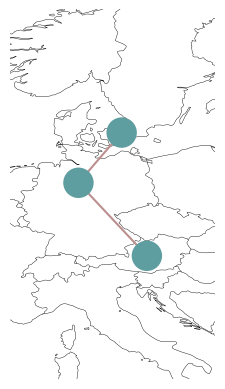

In [8]:
n.plot(bus_sizes=1, margin=1)

In [9]:

# Co2 Cap
CO2_limit = (152 + 4.9 + 6.0) #MtCO2 just electricity

n.add(
    "GlobalConstraint",
    "CO2Limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant= CO2_limit * 1000000, #152MtCO2 for GE + 6.0 for DK (https://www.nowtricity.com/country/denmark/) + 4.9 for AT (https://www.nowtricity.com/country/austria)
)


Index(['CO2Limit'], dtype='object')

In [10]:
n.optimize(solver_name='gurobi')


Index(['DEU-DNK', 'DEU-AUT'], dtype='object', name='Line')
Index(['DEU', 'DNK', 'AUT'], dtype='object', name='Bus')
Index(['DEU-DNK', 'DEU-AUT'], dtype='object', name='Line')
Index(['DEU', 'DNK', 'AUT'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.82it/s]
INFO:linopy.io: Writing time: 3.33s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2620854


INFO:gurobipy:Set parameter LicenseID to value 2620854


Academic license - for non-commercial use only - expires 2026-02-11


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-11


Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-s3si8i0l.lp


INFO:gurobipy:Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-s3si8i0l.lp


Reading time = 1.22 seconds


INFO:gurobipy:Reading time = 1.22 seconds


obj: 499336 rows, 227775 columns, 1012000 nonzeros


INFO:gurobipy:obj: 499336 rows, 227775 columns, 1012000 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:


CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 499336 rows, 227775 columns and 1012000 nonzeros


INFO:gurobipy:Optimize a model with 499336 rows, 227775 columns and 1012000 nonzeros


Model fingerprint: 0xa45e9cb0


INFO:gurobipy:Model fingerprint: 0xa45e9cb0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 2e+03]


INFO:gurobipy:  Matrix range     [1e-03, 2e+03]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [1e+03, 6e+03]


INFO:gurobipy:  Bounds range     [1e+03, 6e+03]


  RHS range        [1e+03, 2e+08]


INFO:gurobipy:  RHS range        [1e+03, 2e+08]


Presolve removed 249469 rows and 12934 columns


INFO:gurobipy:Presolve removed 249469 rows and 12934 columns


Presolve time: 1.00s


INFO:gurobipy:Presolve time: 1.00s


Presolved: 249867 rows, 214841 columns, 749597 nonzeros


INFO:gurobipy:Presolved: 249867 rows, 214841 columns, 749597 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.34s


INFO:gurobipy:Ordering time: 0.34s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 15


INFO:gurobipy: Dense cols : 15


 AA' NZ     : 6.311e+05


INFO:gurobipy: AA' NZ     : 6.311e+05


 Factor NZ  : 4.485e+06 (roughly 220 MB of memory)


INFO:gurobipy: Factor NZ  : 4.485e+06 (roughly 220 MB of memory)


 Factor Ops : 9.751e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 9.751e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.05020884e+13 -4.54097143e+11  5.10e+10 0.00e+00  4.60e+09     2s


INFO:gurobipy:   0   1.05020884e+13 -4.54097143e+11  5.10e+10 0.00e+00  4.60e+09     2s


   1   1.36058692e+13 -1.55555053e+12  9.77e+09 3.20e+02  1.05e+09     3s


INFO:gurobipy:   1   1.36058692e+13 -1.55555053e+12  9.77e+09 3.20e+02  1.05e+09     3s


   2   1.10062055e+13 -1.55782459e+12  1.31e+09 6.89e+01  2.26e+08     3s


INFO:gurobipy:   2   1.10062055e+13 -1.55782459e+12  1.31e+09 6.89e+01  2.26e+08     3s


   3   4.47210853e+12 -8.74253439e+11  1.11e+08 8.32e+00  3.38e+07     4s


INFO:gurobipy:   3   4.47210853e+12 -8.74253439e+11  1.11e+08 8.32e+00  3.38e+07     4s


   4   2.07321038e+12 -2.91054862e+11  2.84e+07 1.18e+00  8.01e+06     4s


INFO:gurobipy:   4   2.07321038e+12 -2.91054862e+11  2.84e+07 1.18e+00  8.01e+06     4s


   5   8.31650308e+11 -6.34010708e+10  7.54e+06 1.42e-01  2.36e+06     5s


INFO:gurobipy:   5   8.31650308e+11 -6.34010708e+10  7.54e+06 1.42e-01  2.36e+06     5s


   6   2.56411368e+11 -1.36310689e+10  1.71e+06 3.54e-02  6.68e+05     5s


INFO:gurobipy:   6   2.56411368e+11 -1.36310689e+10  1.71e+06 3.54e-02  6.68e+05     5s


   7   1.33270299e+11  2.61250494e+09  7.32e+05 1.68e-02  3.16e+05     6s


INFO:gurobipy:   7   1.33270299e+11  2.61250494e+09  7.32e+05 1.68e-02  3.16e+05     6s


   8   9.07978950e+10  1.12293919e+10  4.12e+05 8.99e-03  1.90e+05     6s


INFO:gurobipy:   8   9.07978950e+10  1.12293919e+10  4.12e+05 8.99e-03  1.90e+05     6s


   9   6.84191456e+10  1.59629983e+10  2.64e+05 5.49e-03  1.25e+05     6s


INFO:gurobipy:   9   6.84191456e+10  1.59629983e+10  2.64e+05 5.49e-03  1.25e+05     6s


  10   5.53711728e+10  1.99287925e+10  1.79e+05 2.92e-03  8.37e+04     7s


INFO:gurobipy:  10   5.53711728e+10  1.99287925e+10  1.79e+05 2.92e-03  8.37e+04     7s


  11   4.85372771e+10  2.25328865e+10  1.33e+05 1.52e-03  6.12e+04     7s


INFO:gurobipy:  11   4.85372771e+10  2.25328865e+10  1.33e+05 1.52e-03  6.12e+04     7s


  12   4.18632912e+10  2.47658059e+10  8.65e+04 5.90e-04  4.01e+04     7s


INFO:gurobipy:  12   4.18632912e+10  2.47658059e+10  8.65e+04 5.90e-04  4.01e+04     7s


  13   3.82876015e+10  2.61859923e+10  6.16e+04 1.90e-04  2.84e+04     8s


INFO:gurobipy:  13   3.82876015e+10  2.61859923e+10  6.16e+04 1.90e-04  2.84e+04     8s


  14   3.55434174e+10  2.72882964e+10  4.13e+04 2.01e-09  1.93e+04     8s


INFO:gurobipy:  14   3.55434174e+10  2.72882964e+10  4.13e+04 2.01e-09  1.93e+04     8s


  15   3.52155827e+10  2.76853838e+10  3.87e+04 7.39e-10  1.76e+04     9s


INFO:gurobipy:  15   3.52155827e+10  2.76853838e+10  3.87e+04 7.39e-10  1.76e+04     9s


  16   3.49319156e+10  2.82063524e+10  3.66e+04 1.84e-10  1.57e+04     9s


INFO:gurobipy:  16   3.49319156e+10  2.82063524e+10  3.66e+04 1.84e-10  1.57e+04     9s


  17   3.35686172e+10  2.84880479e+10  2.66e+04 5.00e-10  1.19e+04     9s


INFO:gurobipy:  17   3.35686172e+10  2.84880479e+10  2.66e+04 5.00e-10  1.19e+04     9s


  18   3.28142061e+10  2.85214761e+10  2.09e+04 1.48e-09  1.00e+04    10s


INFO:gurobipy:  18   3.28142061e+10  2.85214761e+10  2.09e+04 1.48e-09  1.00e+04    10s


  19   3.25862698e+10  2.86465418e+10  1.92e+04 5.96e-10  9.22e+03    10s


INFO:gurobipy:  19   3.25862698e+10  2.86465418e+10  1.92e+04 5.96e-10  9.22e+03    10s


  20   3.23981544e+10  2.88562401e+10  1.79e+04 3.81e-10  8.28e+03    11s


INFO:gurobipy:  20   3.23981544e+10  2.88562401e+10  1.79e+04 3.81e-10  8.28e+03    11s


  21   3.21449813e+10  2.90098870e+10  1.61e+04 1.12e-09  7.33e+03    11s


INFO:gurobipy:  21   3.21449813e+10  2.90098870e+10  1.61e+04 1.12e-09  7.33e+03    11s


  22   3.20405548e+10  2.90992013e+10  1.52e+04 5.44e-10  6.88e+03    12s


INFO:gurobipy:  22   3.20405548e+10  2.90992013e+10  1.52e+04 5.44e-10  6.88e+03    12s


  23   3.18398890e+10  2.92898752e+10  1.36e+04 7.35e-10  5.96e+03    12s


INFO:gurobipy:  23   3.18398890e+10  2.92898752e+10  1.36e+04 7.35e-10  5.96e+03    12s


  24   3.15941535e+10  2.93812128e+10  1.13e+04 9.01e-10  5.17e+03    12s


INFO:gurobipy:  24   3.15941535e+10  2.93812128e+10  1.13e+04 9.01e-10  5.17e+03    12s


  25   3.12103883e+10  2.95418411e+10  7.84e+03 6.54e-09  3.90e+03    13s


INFO:gurobipy:  25   3.12103883e+10  2.95418411e+10  7.84e+03 6.54e-09  3.90e+03    13s


  26   3.10202182e+10  2.96534220e+10  6.32e+03 1.31e-08  3.20e+03    13s


INFO:gurobipy:  26   3.10202182e+10  2.96534220e+10  6.32e+03 1.31e-08  3.20e+03    13s


  27   3.09072214e+10  2.97253856e+10  5.19e+03 1.66e-08  2.76e+03    14s


INFO:gurobipy:  27   3.09072214e+10  2.97253856e+10  5.19e+03 1.66e-08  2.76e+03    14s


  28   3.07287715e+10  2.98456939e+10  3.55e+03 2.01e-08  2.06e+03    14s


INFO:gurobipy:  28   3.07287715e+10  2.98456939e+10  3.55e+03 2.01e-08  2.06e+03    14s


  29   3.06592105e+10  2.98952592e+10  3.01e+03 1.97e-08  1.79e+03    15s


INFO:gurobipy:  29   3.06592105e+10  2.98952592e+10  3.01e+03 1.97e-08  1.79e+03    15s


  30   3.06229101e+10  2.99533316e+10  2.74e+03 1.69e-08  1.57e+03    15s


INFO:gurobipy:  30   3.06229101e+10  2.99533316e+10  2.74e+03 1.69e-08  1.57e+03    15s


  31   3.05556573e+10  2.99776144e+10  2.21e+03 1.55e-08  1.35e+03    15s


INFO:gurobipy:  31   3.05556573e+10  2.99776144e+10  2.21e+03 1.55e-08  1.35e+03    15s


  32   3.05269253e+10  3.00085279e+10  1.96e+03 1.57e-08  1.21e+03    16s


INFO:gurobipy:  32   3.05269253e+10  3.00085279e+10  1.96e+03 1.57e-08  1.21e+03    16s


  33   3.05044878e+10  3.00277209e+10  1.74e+03 1.55e-08  1.11e+03    16s


INFO:gurobipy:  33   3.05044878e+10  3.00277209e+10  1.74e+03 1.55e-08  1.11e+03    16s


  34   3.04427004e+10  3.00773769e+10  1.17e+03 1.37e-08  8.54e+02    17s


INFO:gurobipy:  34   3.04427004e+10  3.00773769e+10  1.17e+03 1.37e-08  8.54e+02    17s


  35   3.04203346e+10  3.01380086e+10  9.87e+02 1.30e-08  6.60e+02    17s


INFO:gurobipy:  35   3.04203346e+10  3.01380086e+10  9.87e+02 1.30e-08  6.60e+02    17s


  36   3.04056782e+10  3.01615413e+10  8.75e+02 1.27e-08  5.71e+02    18s


INFO:gurobipy:  36   3.04056782e+10  3.01615413e+10  8.75e+02 1.27e-08  5.71e+02    18s


  37   3.03860628e+10  3.01836065e+10  7.34e+02 1.69e-08  4.73e+02    18s


INFO:gurobipy:  37   3.03860628e+10  3.01836065e+10  7.34e+02 1.69e-08  4.73e+02    18s


  38   3.03827665e+10  3.01899761e+10  7.08e+02 1.76e-08  4.51e+02    19s


INFO:gurobipy:  38   3.03827665e+10  3.01899761e+10  7.08e+02 1.76e-08  4.51e+02    19s


  39   3.03729429e+10  3.02137129e+10  6.29e+02 2.82e-08  3.72e+02    19s


INFO:gurobipy:  39   3.03729429e+10  3.02137129e+10  6.29e+02 2.82e-08  3.72e+02    19s


  40   3.03629399e+10  3.02318616e+10  5.40e+02 1.72e-08  3.06e+02    19s


INFO:gurobipy:  40   3.03629399e+10  3.02318616e+10  5.40e+02 1.72e-08  3.06e+02    19s


  41   3.03479593e+10  3.02398446e+10  4.21e+02 1.43e-08  2.53e+02    20s


INFO:gurobipy:  41   3.03479593e+10  3.02398446e+10  4.21e+02 1.43e-08  2.53e+02    20s


  42   3.03358530e+10  3.02471927e+10  3.20e+02 1.02e-08  2.07e+02    20s


INFO:gurobipy:  42   3.03358530e+10  3.02471927e+10  3.20e+02 1.02e-08  2.07e+02    20s


  43   3.03339052e+10  3.02561392e+10  3.04e+02 1.12e-08  1.82e+02    21s


INFO:gurobipy:  43   3.03339052e+10  3.02561392e+10  3.04e+02 1.12e-08  1.82e+02    21s


  44   3.03282599e+10  3.02589228e+10  2.59e+02 1.03e-08  1.62e+02    21s


INFO:gurobipy:  44   3.03282599e+10  3.02589228e+10  2.59e+02 1.03e-08  1.62e+02    21s


  45   3.03247766e+10  3.02622615e+10  2.29e+02 8.34e-09  1.46e+02    22s


INFO:gurobipy:  45   3.03247766e+10  3.02622615e+10  2.29e+02 8.34e-09  1.46e+02    22s


  46   3.03194853e+10  3.02668670e+10  1.88e+02 2.94e-09  1.23e+02    22s


INFO:gurobipy:  46   3.03194853e+10  3.02668670e+10  1.88e+02 2.94e-09  1.23e+02    22s


  47   3.03143351e+10  3.02686881e+10  1.46e+02 3.37e-09  1.07e+02    22s


INFO:gurobipy:  47   3.03143351e+10  3.02686881e+10  1.46e+02 3.37e-09  1.07e+02    22s


  48   3.03117980e+10  3.02734310e+10  1.26e+02 3.41e-09  8.97e+01    23s


INFO:gurobipy:  48   3.03117980e+10  3.02734310e+10  1.26e+02 3.41e-09  8.97e+01    23s


  49   3.03102531e+10  3.02760147e+10  1.13e+02 3.23e-09  8.00e+01    24s


INFO:gurobipy:  49   3.03102531e+10  3.02760147e+10  1.13e+02 3.23e-09  8.00e+01    24s


  50   3.03089876e+10  3.02775640e+10  1.03e+02 8.64e-09  7.35e+01    24s


INFO:gurobipy:  50   3.03089876e+10  3.02775640e+10  1.03e+02 8.64e-09  7.35e+01    24s


  51   3.03070646e+10  3.02802209e+10  8.87e+01 1.28e-08  6.27e+01    25s


INFO:gurobipy:  51   3.03070646e+10  3.02802209e+10  8.87e+01 1.28e-08  6.27e+01    25s


  52   3.03067719e+10  3.02811311e+10  8.63e+01 1.28e-08  5.99e+01    25s


INFO:gurobipy:  52   3.03067719e+10  3.02811311e+10  8.63e+01 1.28e-08  5.99e+01    25s


  53   3.03060331e+10  3.02820146e+10  8.09e+01 1.20e-08  5.61e+01    26s


INFO:gurobipy:  53   3.03060331e+10  3.02820146e+10  8.09e+01 1.20e-08  5.61e+01    26s


  54   3.03048599e+10  3.02825782e+10  7.16e+01 1.17e-08  5.21e+01    26s


INFO:gurobipy:  54   3.03048599e+10  3.02825782e+10  7.16e+01 1.17e-08  5.21e+01    26s


  55   3.03042079e+10  3.02835049e+10  6.67e+01 1.11e-08  4.84e+01    27s


INFO:gurobipy:  55   3.03042079e+10  3.02835049e+10  6.67e+01 1.11e-08  4.84e+01    27s


  56   3.03034141e+10  3.02843671e+10  6.09e+01 1.50e-08  4.45e+01    27s


INFO:gurobipy:  56   3.03034141e+10  3.02843671e+10  6.09e+01 1.50e-08  4.45e+01    27s


  57   3.03028900e+10  3.02853236e+10  5.69e+01 2.00e-08  4.11e+01    28s


INFO:gurobipy:  57   3.03028900e+10  3.02853236e+10  5.69e+01 2.00e-08  4.11e+01    28s


  58   3.03021586e+10  3.02857475e+10  5.16e+01 1.59e-08  3.84e+01    28s


INFO:gurobipy:  58   3.03021586e+10  3.02857475e+10  5.16e+01 1.59e-08  3.84e+01    28s


  59   3.03016163e+10  3.02864815e+10  4.77e+01 1.49e-08  3.54e+01    29s


INFO:gurobipy:  59   3.03016163e+10  3.02864815e+10  4.77e+01 1.49e-08  3.54e+01    29s


  60   3.03010853e+10  3.02875228e+10  4.39e+01 2.81e-08  3.17e+01    29s


INFO:gurobipy:  60   3.03010853e+10  3.02875228e+10  4.39e+01 2.81e-08  3.17e+01    29s


  61   3.03005123e+10  3.02878034e+10  3.96e+01 3.33e-08  2.97e+01    30s


INFO:gurobipy:  61   3.03005123e+10  3.02878034e+10  3.96e+01 3.33e-08  2.97e+01    30s


  62   3.03000319e+10  3.02881892e+10  3.56e+01 3.21e-08  2.77e+01    30s


INFO:gurobipy:  62   3.03000319e+10  3.02881892e+10  3.56e+01 3.21e-08  2.77e+01    30s


  63   3.02995966e+10  3.02888955e+10  3.20e+01 3.33e-08  2.50e+01    30s


INFO:gurobipy:  63   3.02995966e+10  3.02888955e+10  3.20e+01 3.33e-08  2.50e+01    30s


  64   3.02993291e+10  3.02893132e+10  3.00e+01 3.17e-08  2.34e+01    31s


INFO:gurobipy:  64   3.02993291e+10  3.02893132e+10  3.00e+01 3.17e-08  2.34e+01    31s


  65   3.02990548e+10  3.02897202e+10  2.79e+01 3.26e-08  2.18e+01    31s


INFO:gurobipy:  65   3.02990548e+10  3.02897202e+10  2.79e+01 3.26e-08  2.18e+01    31s


  66   3.02988390e+10  3.02901990e+10  2.61e+01 3.77e-08  2.02e+01    32s


INFO:gurobipy:  66   3.02988390e+10  3.02901990e+10  2.61e+01 3.77e-08  2.02e+01    32s


  67   3.02987102e+10  3.02904078e+10  2.49e+01 4.12e-08  1.94e+01    32s


INFO:gurobipy:  67   3.02987102e+10  3.02904078e+10  2.49e+01 4.12e-08  1.94e+01    32s


  68   3.02983517e+10  3.02907986e+10  2.20e+01 3.71e-08  1.77e+01    32s


INFO:gurobipy:  68   3.02983517e+10  3.02907986e+10  2.20e+01 3.71e-08  1.77e+01    32s


  69   3.02982182e+10  3.02909631e+10  2.10e+01 4.67e-08  1.70e+01    33s


INFO:gurobipy:  69   3.02982182e+10  3.02909631e+10  2.10e+01 4.67e-08  1.70e+01    33s


  70   3.02980517e+10  3.02911705e+10  1.97e+01 5.83e-08  1.61e+01    33s


INFO:gurobipy:  70   3.02980517e+10  3.02911705e+10  1.97e+01 5.83e-08  1.61e+01    33s


  71   3.02978603e+10  3.02915632e+10  1.83e+01 6.78e-08  1.47e+01    33s


INFO:gurobipy:  71   3.02978603e+10  3.02915632e+10  1.83e+01 6.78e-08  1.47e+01    33s


  72   3.02976690e+10  3.02918854e+10  1.67e+01 7.69e-08  1.35e+01    34s


INFO:gurobipy:  72   3.02976690e+10  3.02918854e+10  1.67e+01 7.69e-08  1.35e+01    34s


  73   3.02974746e+10  3.02921093e+10  1.52e+01 1.15e-07  1.25e+01    34s


INFO:gurobipy:  73   3.02974746e+10  3.02921093e+10  1.52e+01 1.15e-07  1.25e+01    34s


  74   3.02973063e+10  3.02924157e+10  1.38e+01 1.19e-07  1.14e+01    35s


INFO:gurobipy:  74   3.02973063e+10  3.02924157e+10  1.38e+01 1.19e-07  1.14e+01    35s


  75   3.02971577e+10  3.02924659e+10  1.26e+01 1.10e-07  1.10e+01    35s


INFO:gurobipy:  75   3.02971577e+10  3.02924659e+10  1.26e+01 1.10e-07  1.10e+01    35s


  76   3.02970196e+10  3.02927061e+10  1.16e+01 1.18e-07  1.01e+01    35s


INFO:gurobipy:  76   3.02970196e+10  3.02927061e+10  1.16e+01 1.18e-07  1.01e+01    35s


  77   3.02968393e+10  3.02929473e+10  1.05e+01 1.64e-07  9.10e+00    36s


INFO:gurobipy:  77   3.02968393e+10  3.02929473e+10  1.05e+01 1.64e-07  9.10e+00    36s


  78   3.02967431e+10  3.02931187e+10  9.75e+00 1.52e-07  8.47e+00    36s


INFO:gurobipy:  78   3.02967431e+10  3.02931187e+10  9.75e+00 1.52e-07  8.47e+00    36s


  79   3.02966649e+10  3.02932493e+10  9.15e+00 1.80e-07  7.99e+00    37s


INFO:gurobipy:  79   3.02966649e+10  3.02932493e+10  9.15e+00 1.80e-07  7.99e+00    37s


  80   3.02966427e+10  3.02932936e+10  8.98e+00 1.84e-07  7.83e+00    37s


INFO:gurobipy:  80   3.02966427e+10  3.02932936e+10  8.98e+00 1.84e-07  7.83e+00    37s


  81   3.02965895e+10  3.02933855e+10  8.59e+00 1.93e-07  7.49e+00    37s


INFO:gurobipy:  81   3.02965895e+10  3.02933855e+10  8.59e+00 1.93e-07  7.49e+00    37s


  82   3.02965191e+10  3.02935054e+10  8.07e+00 2.26e-07  7.05e+00    38s


INFO:gurobipy:  82   3.02965191e+10  3.02935054e+10  8.07e+00 2.26e-07  7.05e+00    38s


  83   3.02964098e+10  3.02936062e+10  7.19e+00 2.67e-07  6.56e+00    38s


INFO:gurobipy:  83   3.02964098e+10  3.02936062e+10  7.19e+00 2.67e-07  6.56e+00    38s


  84   3.02963250e+10  3.02938244e+10  6.42e+00 1.20e-07  5.85e+00    39s


INFO:gurobipy:  84   3.02963250e+10  3.02938244e+10  6.42e+00 1.20e-07  5.85e+00    39s


  85   3.02961766e+10  3.02940258e+10  5.23e+00 1.01e-07  5.03e+00    39s


INFO:gurobipy:  85   3.02961766e+10  3.02940258e+10  5.23e+00 1.01e-07  5.03e+00    39s


  86   3.02960737e+10  3.02941410e+10  4.41e+00 1.02e-07  4.52e+00    39s


INFO:gurobipy:  86   3.02960737e+10  3.02941410e+10  4.41e+00 1.02e-07  4.52e+00    39s


  87   3.02960183e+10  3.02941894e+10  3.98e+00 1.04e-07  4.28e+00    40s


INFO:gurobipy:  87   3.02960183e+10  3.02941894e+10  3.98e+00 1.04e-07  4.28e+00    40s


  88   3.02959591e+10  3.02942430e+10  3.57e+00 1.53e-07  4.01e+00    40s


INFO:gurobipy:  88   3.02959591e+10  3.02942430e+10  3.57e+00 1.53e-07  4.01e+00    40s


  89   3.02959402e+10  3.02942756e+10  3.46e+00 2.16e-07  3.89e+00    41s


INFO:gurobipy:  89   3.02959402e+10  3.02942756e+10  3.46e+00 2.16e-07  3.89e+00    41s


  90   3.02959037e+10  3.02943609e+10  3.23e+00 1.95e-07  3.61e+00    41s


INFO:gurobipy:  90   3.02959037e+10  3.02943609e+10  3.23e+00 1.95e-07  3.61e+00    41s


  91   3.02958735e+10  3.02944403e+10  2.94e+00 1.84e-07  3.35e+00    41s


INFO:gurobipy:  91   3.02958735e+10  3.02944403e+10  2.94e+00 1.84e-07  3.35e+00    41s


  92   3.02958184e+10  3.02945451e+10  2.50e+00 1.68e-07  2.98e+00    42s


INFO:gurobipy:  92   3.02958184e+10  3.02945451e+10  2.50e+00 1.68e-07  2.98e+00    42s


  93   3.02957727e+10  3.02946038e+10  2.15e+00 1.78e-07  2.73e+00    42s


INFO:gurobipy:  93   3.02957727e+10  3.02946038e+10  2.15e+00 1.78e-07  2.73e+00    42s


  94   3.02957453e+10  3.02946595e+10  1.92e+00 2.27e-07  2.54e+00    43s


INFO:gurobipy:  94   3.02957453e+10  3.02946595e+10  1.92e+00 2.27e-07  2.54e+00    43s


  95   3.02957184e+10  3.02947422e+10  1.72e+00 4.12e-07  2.28e+00    43s


INFO:gurobipy:  95   3.02957184e+10  3.02947422e+10  1.72e+00 4.12e-07  2.28e+00    43s


  96   3.02956856e+10  3.02948111e+10  1.47e+00 3.21e-06  2.05e+00    43s


INFO:gurobipy:  96   3.02956856e+10  3.02948111e+10  1.47e+00 3.21e-06  2.05e+00    43s


  97   3.02956729e+10  3.02948640e+10  1.37e+00 6.67e-07  1.89e+00    44s


INFO:gurobipy:  97   3.02956729e+10  3.02948640e+10  1.37e+00 6.67e-07  1.89e+00    44s


  98   3.02956486e+10  3.02949660e+10  1.15e+00 5.09e-07  1.60e+00    44s


INFO:gurobipy:  98   3.02956486e+10  3.02949660e+10  1.15e+00 5.09e-07  1.60e+00    44s


  99   3.02956458e+10  3.02950643e+10  1.12e+00 2.01e-06  1.36e+00    44s


INFO:gurobipy:  99   3.02956458e+10  3.02950643e+10  1.12e+00 2.01e-06  1.36e+00    44s


 100   3.02956327e+10  3.02951320e+10  1.02e+00 1.40e-06  1.17e+00    45s


INFO:gurobipy: 100   3.02956327e+10  3.02951320e+10  1.02e+00 1.40e-06  1.17e+00    45s


 101   3.02956219e+10  3.02951418e+10  9.32e-01 2.06e-06  1.12e+00    45s


INFO:gurobipy: 101   3.02956219e+10  3.02951418e+10  9.32e-01 2.06e-06  1.12e+00    45s


 102   3.02956018e+10  3.02952030e+10  7.83e-01 1.75e-06  9.33e-01    46s


INFO:gurobipy: 102   3.02956018e+10  3.02952030e+10  7.83e-01 1.75e-06  9.33e-01    46s


 103   3.02955999e+10  3.02952305e+10  7.47e-01 2.26e-06  8.64e-01    46s


INFO:gurobipy: 103   3.02955999e+10  3.02952305e+10  7.47e-01 2.26e-06  8.64e-01    46s


 104   3.02955802e+10  3.02953170e+10  6.04e-01 3.08e-06  6.15e-01    46s


INFO:gurobipy: 104   3.02955802e+10  3.02953170e+10  6.04e-01 3.08e-06  6.15e-01    46s


 105   3.02955790e+10  3.02953206e+10  5.73e-01 3.06e-06  6.04e-01    47s


INFO:gurobipy: 105   3.02955790e+10  3.02953206e+10  5.73e-01 3.06e-06  6.04e-01    47s


 106   3.02955594e+10  3.02953370e+10  4.29e-01 4.39e-06  5.20e-01    47s


INFO:gurobipy: 106   3.02955594e+10  3.02953370e+10  4.29e-01 4.39e-06  5.20e-01    47s


 107   3.02955498e+10  3.02953835e+10  3.58e-01 5.17e-06  3.89e-01    47s


INFO:gurobipy: 107   3.02955498e+10  3.02953835e+10  3.58e-01 5.17e-06  3.89e-01    47s


 108   3.02955414e+10  3.02953925e+10  2.90e-01 4.79e-06  3.48e-01    48s


INFO:gurobipy: 108   3.02955414e+10  3.02953925e+10  2.90e-01 4.79e-06  3.48e-01    48s


 109   3.02955334e+10  3.02954095e+10  2.28e-01 4.07e-06  2.90e-01    48s


INFO:gurobipy: 109   3.02955334e+10  3.02954095e+10  2.28e-01 4.07e-06  2.90e-01    48s


 110   3.02955290e+10  3.02954234e+10  1.94e-01 3.32e-06  2.47e-01    49s


INFO:gurobipy: 110   3.02955290e+10  3.02954234e+10  1.94e-01 3.32e-06  2.47e-01    49s


 111   3.02955084e+10  3.02954558e+10  1.16e-05 1.97e-06  1.23e-01    49s


INFO:gurobipy: 111   3.02955084e+10  3.02954558e+10  1.16e-05 1.97e-06  1.23e-01    49s


 112   3.02955078e+10  3.02954624e+10  1.04e-05 1.67e-06  1.06e-01    50s


INFO:gurobipy: 112   3.02955078e+10  3.02954624e+10  1.04e-05 1.67e-06  1.06e-01    50s


 113   3.02955071e+10  3.02954912e+10  8.70e-06 4.56e-07  3.71e-02    50s


INFO:gurobipy: 113   3.02955071e+10  3.02954912e+10  8.70e-06 4.56e-07  3.71e-02    50s


 114   3.02955046e+10  3.02955009e+10  9.90e-06 6.76e-08  8.69e-03    50s


INFO:gurobipy: 114   3.02955046e+10  3.02955009e+10  9.90e-06 6.76e-08  8.69e-03    50s


 115   3.02955043e+10  3.02955015e+10  2.07e-06 5.38e-08  6.62e-03    51s


INFO:gurobipy: 115   3.02955043e+10  3.02955015e+10  2.07e-06 5.38e-08  6.62e-03    51s


 116   3.02955043e+10  3.02955017e+10  1.81e-06 5.01e-08  6.17e-03    51s


INFO:gurobipy: 116   3.02955043e+10  3.02955017e+10  1.81e-06 5.01e-08  6.17e-03    51s


 117   3.02955043e+10  3.02955025e+10  1.70e-06 3.44e-08  4.29e-03    51s


INFO:gurobipy: 117   3.02955043e+10  3.02955025e+10  1.70e-06 3.44e-08  4.29e-03    51s


 118   3.02955043e+10  3.02955042e+10  1.30e-06 1.61e-09  3.30e-04    52s


INFO:gurobipy: 118   3.02955043e+10  3.02955042e+10  1.30e-06 1.61e-09  3.30e-04    52s


 119   3.02955043e+10  3.02955042e+10  7.09e-05 3.32e-09  7.23e-05    52s


INFO:gurobipy: 119   3.02955043e+10  3.02955042e+10  7.09e-05 3.32e-09  7.23e-05    52s


 120   3.02955043e+10  3.02955043e+10  9.20e-07 1.58e-08  3.04e-07    53s


INFO:gurobipy: 120   3.02955043e+10  3.02955043e+10  9.20e-07 1.58e-08  3.04e-07    53s


 121   3.02955043e+10  3.02955043e+10  3.65e-05 1.05e-08  1.43e-10    53s


INFO:gurobipy: 121   3.02955043e+10  3.02955043e+10  3.65e-05 1.05e-08  1.43e-10    53s


INFO:gurobipy:


Barrier solved model in 121 iterations and 52.89 seconds (19.79 work units)


INFO:gurobipy:Barrier solved model in 121 iterations and 52.89 seconds (19.79 work units)


Optimal objective 3.02955043e+10


INFO:gurobipy:Optimal objective 3.02955043e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   62097 DPushes remaining with DInf 0.0000000e+00                53s


INFO:gurobipy:   62097 DPushes remaining with DInf 0.0000000e+00                53s


       0 DPushes remaining with DInf 0.0000000e+00                54s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                54s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


   29854 PPushes remaining with PInf 0.0000000e+00                54s


INFO:gurobipy:   29854 PPushes remaining with PInf 0.0000000e+00                54s


   25931 PPushes remaining with PInf 0.0000000e+00                58s


INFO:gurobipy:   25931 PPushes remaining with PInf 0.0000000e+00                58s


   20434 PPushes remaining with PInf 0.0000000e+00                62s


INFO:gurobipy:   20434 PPushes remaining with PInf 0.0000000e+00                62s


   18754 PPushes remaining with PInf 0.0000000e+00                65s


INFO:gurobipy:   18754 PPushes remaining with PInf 0.0000000e+00                65s


   15169 PPushes remaining with PInf 0.0000000e+00                70s


INFO:gurobipy:   15169 PPushes remaining with PInf 0.0000000e+00                70s


   12031 PPushes remaining with PInf 0.0000000e+00                75s


INFO:gurobipy:   12031 PPushes remaining with PInf 0.0000000e+00                75s


    9510 PPushes remaining with PInf 0.0000000e+00                80s


INFO:gurobipy:    9510 PPushes remaining with PInf 0.0000000e+00                80s


    7247 PPushes remaining with PInf 0.0000000e+00                85s


INFO:gurobipy:    7247 PPushes remaining with PInf 0.0000000e+00                85s


    4743 PPushes remaining with PInf 0.0000000e+00                91s


INFO:gurobipy:    4743 PPushes remaining with PInf 0.0000000e+00                91s


    2807 PPushes remaining with PInf 0.0000000e+00                95s


INFO:gurobipy:    2807 PPushes remaining with PInf 0.0000000e+00                95s


     331 PPushes remaining with PInf 0.0000000e+00               100s


INFO:gurobipy:     331 PPushes remaining with PInf 0.0000000e+00               100s


       0 PPushes remaining with PInf 0.0000000e+00               102s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00               102s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.5131626e-08    102s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.5131626e-08    102s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 2


INFO:gurobipy:Extra simplex iterations after uncrush: 2


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   59129    3.0295504e+10   0.000000e+00   0.000000e+00    104s


INFO:gurobipy:   59129    3.0295504e+10   0.000000e+00   0.000000e+00    104s


INFO:gurobipy:


Solved in 59129 iterations and 103.56 seconds (103.15 work units)


INFO:gurobipy:Solved in 59129 iterations and 103.56 seconds (103.15 work units)


Optimal objective  3.029550426e+10


INFO:gurobipy:Optimal objective  3.029550426e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 227775 primals, 499336 duals
Objective: 3.03e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Line-fix-s-lower, Line-fix-s-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

In [11]:
colors

{'onshore': 'blue',
 'offshore': 'darkblue',
 'pv': 'orange',
 'rooftop': 'yellow',
 'coal': 'brown',
 'OCGT': 'grey'}

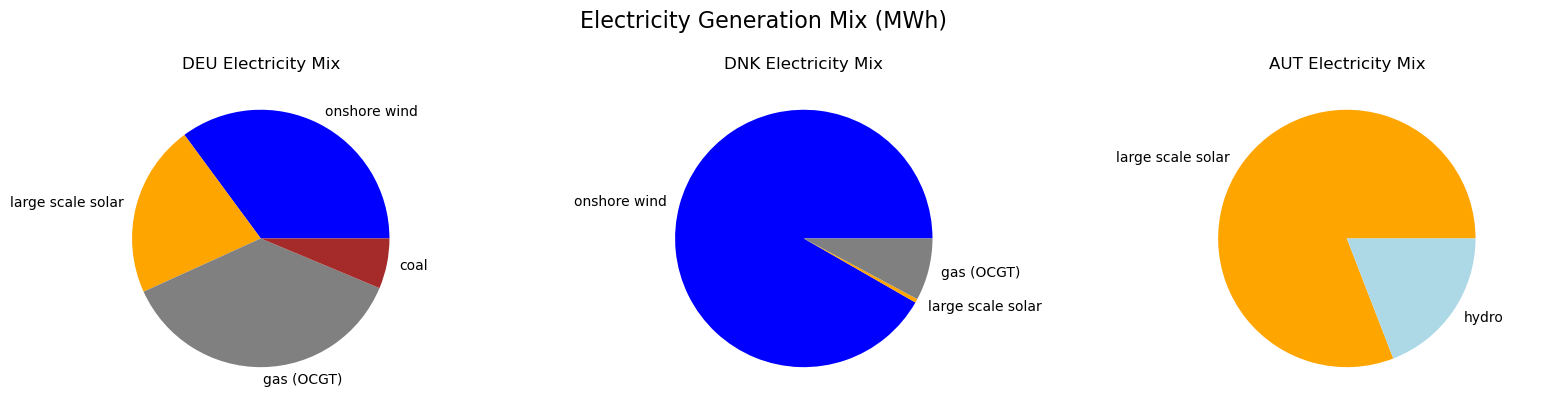

In [12]:
colors_gen = {
    'onshore wind': 'blue',
    'offshore wind': 'darkblue',
    'large scale solar': 'orange',
    'gas (OCGT)': 'grey',
    'coal': 'brown',
    'hydro': 'lightblue'
}

plt.figure(figsize=(16, 4))

for i, country in enumerate(countries):
    labels = []
    sizes = []

    # Onshore wind
    if f'onshorewind{country}' in n.generators.index:
        value = n.generators_t.p[f'onshorewind{country}'].sum()
        if value > 0.1:
            labels.append('onshore wind')
            sizes.append(value)

    # Offshore wind
    if f'offshorewind{country}' in n.generators.index:
        value = n.generators_t.p[f'offshorewind{country}'].sum()
        if value > 0.1:
            labels.append('offshore wind')
            sizes.append(value)

    # PV
    if f'PV{country}' in n.generators.index:
        value = n.generators_t.p[f'PV{country}'].sum()
        if value > 0.1:
            labels.append('large scale solar')
            sizes.append(value)

    # OCGT
    if f'OCGT{country}' in n.generators.index:
        value = n.generators_t.p[f'OCGT{country}'].sum()
        if value > 0.1:
            labels.append('gas (OCGT)')
            sizes.append(value)

    # Coal
    if f'coal{country}' in n.generators.index:
        value = n.generators_t.p[f'coal{country}'].sum()
        if value > 0.1:
            labels.append('coal')
            sizes.append(value)

    # Hydro (storage unit dispatch)
    if f"hydro{country}" in n.storage_units.index:
        value = n.storage_units_t.p[f"hydro{country}"].sum()
        if value > 0.1:
            labels.append('hydro')
            sizes.append(value)

    if sizes:
        colors = [colors_gen[label] for label in labels]
        plt.subplot(1, 3, i + 1)
        plt.pie(sizes, labels=labels, colors=colors, wedgeprops={'linewidth': 0})
        plt.axis('equal')
        plt.title(f"{country} Electricity Mix", y=1.07)
    else:
        plt.subplot(1, 3, i + 1)
        plt.text(0.5, 0.5, 'No generation', ha='center', va='center')
        plt.axis('off')

plt.suptitle("Electricity Generation Mix (MWh)", fontsize=16)
plt.tight_layout()
plt.show()


<Axes: xlabel='snapshot'>

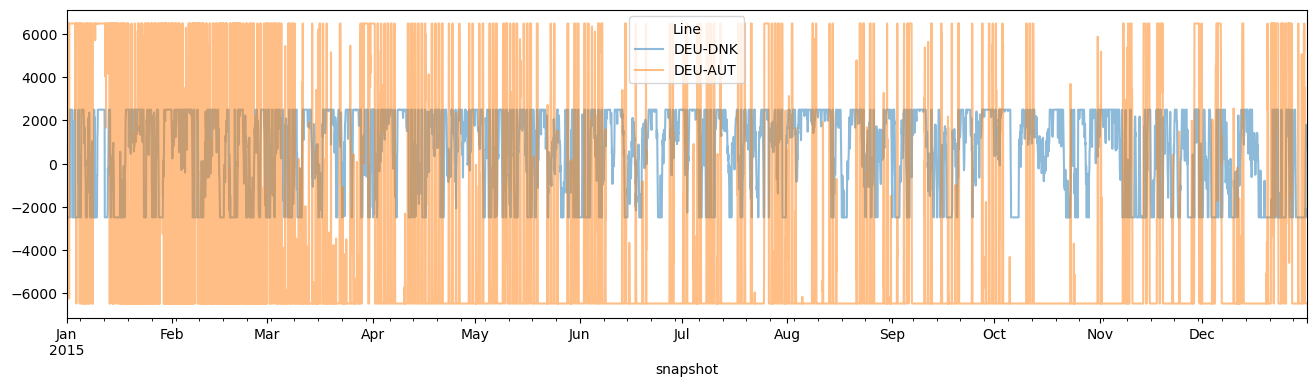

In [13]:
n.lines_t.p0.plot(figsize=(16, 4), alpha=0.5)

# Section G: Connecting to Heating sector

In [14]:
# Retrieve the heating demand data
heating_demand = pd.read_csv('data/heat_demand.csv', sep=';', index_col=0) # in MWh
heating_demand.index = pd.to_datetime(heating_demand.index) #change index to datatime

# Retrieve some capital cost data
year = 2030
url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_{year}.csv"
costs = pd.read_csv(url, index_col=[0, 1])
costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

defaults = {
    "FOM": 0,
    "VOM": 0,
    "efficiency": 1,
    "fuel": 0,
    "investment": 0,
    "lifetime": 25,
    "CO2 intensity": 0,
    "discount rate": 0.07,
}
costs = costs.value.unstack().fillna(defaults)
costs["marginal_cost"] = costs["VOM"] + costs["fuel"] / costs["efficiency"]
annuity = costs.apply(lambda x: annuity(x["discount rate"], x["lifetime"]), axis=1)
costs["capital_cost"] = (annuity + costs["FOM"] / 100) * costs["investment"]
costs.at["central air-sourced heat pump", "capital_cost"]

111082358.72659878

In [15]:
for country in countries:
      # add heat bus for each country
      n.add("Bus", f"{country}_heat", carrier="heat")

      # add heat load to the bus for each country
      n.add("Load",
            f"heat_load_{country}",
            bus=f"{country}_heat",
            p_set=heating_demand[country].values)

      # Add heat pump, assuming fixed COP. Would be nice to have a variable COP, but require temperature data for each country
      fixed_cop = 2.8 # Reasonable average for the chosen countries

      n.add("Link",
            f"heat_pump_{country}",
            bus0=country,              # electricity input
            bus1=f"{country}_heat",    # heat output
            efficiency=fixed_cop,
            p_nom_extendable=True,
            carrier="heat pump",
            capital_cost=costs.at["central air-sourced heat pump", "capital_cost"],
            bidirectional=False)

      # Add CHP unit. Assume there are already withing the system
      n.add("Link",
            f"CHP_{country}",
            bus0="gas",                # gas input
            bus1=country,              # electricity output
            bus2=f"{country}_heat",    # heat output
            efficiency=0.4,            # electric efficiency
            efficiency2=0.4,           # heat efficiency
            p_nom_extendable=True,
            carrier="CHP",
            marginal_cost=80) # in €/MWh_el

Index(['CHP_DEU'], dtype='object')
Index(['CHP_DNK'], dtype='object')
Index(['CHP_AUT'], dtype='object')


In [16]:
def annuity(n,r):
    """ Calculate the annuity factor for an asset with lifetime n years and
    discount rate  r """

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n

In [17]:
n.add("Carrier", "H2", co2_emissions=0)
for country in countries:
    n.add("Bus", f"{country}_H2", carrier="H2")
    n.add("Link",
          f"electrolyzer_{country}",
          bus0=country,               # electricity input
          bus1=f"{country}_H2",        # hydrogen output
          efficiency=0.8,
          p_nom_extendable=True,
          carrier="H2 electrolysis",
          capital_cost=annuity(25, 0.07)*600000*(1+0.05),
          bidirectional=False) 
    
    n.add("Store",
          f"H2_tank_{country}",
          bus=f"{country}_H2",
          e_nom_extendable=True,
          e_cyclic=True,
          capital_cost=annuity(25, 0.07)*57000*(1+0.011))
    

    n.add("Link",
          f"H2_heater_{country}",
          bus0=f"{country}_H2",
          bus1=f"{country}_heat",
          efficiency=0.9,
          p_nom_extendable=True,
          carrier="H2 heater",
          marginal_cost=30,  # adjust if needed
          capital_cost=annuity(25, 0.07)*40000,
          bidirectional=False)
    
    n.add("Link",
          f"H2 Fuel Cell_{country}",
          bus0 = f"{country}_H2",
          bus1 = f"{country}",
          p_nom_extendable = True,
          efficiency = 0.58,
          capital_cost = annuity(10, 0.07)*1300000*(1+0.05))


In [18]:
# Add a gas bus
n.add("Bus", "gas", carrier="gas")


# Add a gas store
n.add("Store",
      "gas_store",
      bus="gas",
      e_nom=1e9,  # Very large nominal energy [MWh], to simulate unlimited gas
      e_initial=1e9,
      e_cyclic=True,
      marginal_cost=0)  # Assume gas availability (fuel cost is inside marginal_cost of generators)

# Add a generator that allows gas to enter the system
n.add("Generator",
      "gas_supply",
      bus="gas",
      carrier="gas",
      p_nom=1e6,  # large enough to never limit
      marginal_cost=0)  # or set = 21.6 €/MWh_th if not already in OCGT/CHP costs


Index(['gas_supply'], dtype='object')

In [19]:
n.optimize(solver_name='gurobi')


Index(['0'], dtype='object', name='SubNetwork')
Index(['DEU-DNK', 'DEU-AUT'], dtype='object', name='Line')
Index(['DEU', 'DNK', 'AUT', 'DEU_heat', 'DNK_heat', 'AUT_heat'], dtype='object', name='Bus')
Index(['heat_pump_DEU', 'CHP_DEU', 'heat_pump_DNK', 'CHP_DNK', 'heat_pump_AUT',
       'CHP_AUT', 'electrolyzer_DEU', 'H2_heater_DEU', 'electrolyzer_DNK',
       'H2_heater_DNK', 'electrolyzer_AUT', 'H2_heater_AUT'],
      dtype='object', name='Link')
Index(['0'], dtype='object', name='SubNetwork')
Index(['DEU-DNK', 'DEU-AUT'], dtype='object', name='Line')
Index(['DEU', 'DNK', 'AUT', 'DEU_heat', 'DNK_heat', 'AUT_heat'], dtype='object', name='Bus')
Index(['heat_pump_DEU', 'CHP_DEU', 'heat_pump_DNK', 'CHP_DNK', 'heat_pump_AUT',
       'CHP_AUT', 'electrolyzer_DEU', 'H2_heater_DEU', 'electrolyzer_DNK',
       'H2_heater_DNK', 'electrolyzer_AUT', 'H2_heater_AUT'],
      dtype='object', name='Link')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing c

Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2620854


INFO:gurobipy:Set parameter LicenseID to value 2620854


Academic license - for non-commercial use only - expires 2026-02-11


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-11


Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-6_d127jf.lp


INFO:gurobipy:Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-6_d127jf.lp


Reading time = 1.89 seconds


INFO:gurobipy:Reading time = 1.89 seconds


obj: 946114 rows, 438033 columns, 1966858 nonzeros


INFO:gurobipy:obj: 946114 rows, 438033 columns, 1966858 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:


CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 946114 rows, 438033 columns and 1966858 nonzeros


INFO:gurobipy:Optimize a model with 946114 rows, 438033 columns and 1966858 nonzeros


Model fingerprint: 0x8ba2ccba


INFO:gurobipy:Model fingerprint: 0x8ba2ccba


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 2e+03]


INFO:gurobipy:  Matrix range     [1e-03, 2e+03]


  Objective range  [1e+01, 1e+08]


INFO:gurobipy:  Objective range  [1e+01, 1e+08]


  Bounds range     [1e+03, 6e+03]


INFO:gurobipy:  Bounds range     [1e+03, 6e+03]


  RHS range        [1e+03, 1e+09]


INFO:gurobipy:  RHS range        [1e+03, 1e+09]


Presolve removed 503527 rows and 47977 columns


INFO:gurobipy:Presolve removed 503527 rows and 47977 columns


Presolve time: 1.56s


INFO:gurobipy:Presolve time: 1.56s


Presolved: 442587 rows, 390056 columns, 1389077 nonzeros


INFO:gurobipy:Presolved: 442587 rows, 390056 columns, 1389077 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.71s


INFO:gurobipy:Ordering time: 0.71s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 30


INFO:gurobipy: Dense cols : 30


 AA' NZ     : 1.201e+06


INFO:gurobipy: AA' NZ     : 1.201e+06


 Factor NZ  : 7.276e+06 (roughly 400 MB of memory)


INFO:gurobipy: Factor NZ  : 7.276e+06 (roughly 400 MB of memory)


 Factor Ops : 2.021e+08 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 2.021e+08 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.26165586e+15 -7.14799950e+16  8.84e+10 0.00e+00  1.82e+11     4s


INFO:gurobipy:   0   1.26165586e+15 -7.14799950e+16  8.84e+10 0.00e+00  1.82e+11     4s


   1   7.65026477e+14 -1.88550603e+16  2.07e+10 3.66e+03  4.83e+10     4s


INFO:gurobipy:   1   7.65026477e+14 -1.88550603e+16  2.07e+10 3.66e+03  4.83e+10     4s


   2   2.78975407e+14 -4.52668453e+15  5.15e+09 8.62e+02  1.18e+10     5s


INFO:gurobipy:   2   2.78975407e+14 -4.52668453e+15  5.15e+09 8.62e+02  1.18e+10     5s


   3   7.68650185e+13 -4.71054580e+14  4.65e+08 7.81e+01  1.21e+09     5s


INFO:gurobipy:   3   7.68650185e+13 -4.71054580e+14  4.65e+08 7.81e+01  1.21e+09     5s


   4   3.19412518e+13 -9.69964293e+13  5.35e+07 1.38e+01  2.34e+08     6s


INFO:gurobipy:   4   3.19412518e+13 -9.69964293e+13  5.35e+07 1.38e+01  2.34e+08     6s


   5   1.98899067e+13 -4.26651569e+13  2.55e+07 5.81e+00  1.04e+08     6s


INFO:gurobipy:   5   1.98899067e+13 -4.26651569e+13  2.55e+07 5.81e+00  1.04e+08     6s


   6   1.15373004e+13 -2.20686941e+13  1.25e+07 2.93e+00  5.23e+07     7s


INFO:gurobipy:   6   1.15373004e+13 -2.20686941e+13  1.25e+07 2.93e+00  5.23e+07     7s


   7   7.18164422e+12 -9.33630183e+12  6.62e+06 1.17e+00  2.40e+07     7s


INFO:gurobipy:   7   7.18164422e+12 -9.33630183e+12  6.62e+06 1.17e+00  2.40e+07     7s


   8   3.38953190e+12 -3.01290730e+12  2.44e+06 3.76e-01  8.64e+06     7s


INFO:gurobipy:   8   3.38953190e+12 -3.01290730e+12  2.44e+06 3.76e-01  8.64e+06     7s


   9   1.26954112e+12 -9.16212439e+11  6.19e+05 1.13e-01  2.80e+06     8s


INFO:gurobipy:   9   1.26954112e+12 -9.16212439e+11  6.19e+05 1.13e-01  2.80e+06     8s


  10   7.43301256e+11 -5.79430937e+11  2.76e+05 7.26e-02  1.67e+06     9s


INFO:gurobipy:  10   7.43301256e+11 -5.79430937e+11  2.76e+05 7.26e-02  1.67e+06     9s


  11   5.53809792e+11 -3.33847757e+11  1.60e+05 4.62e-02  1.11e+06     9s


INFO:gurobipy:  11   5.53809792e+11 -3.33847757e+11  1.60e+05 4.62e-02  1.11e+06     9s


  12   4.21398483e+11 -1.54813818e+11  8.78e+04 2.59e-02  7.12e+05     9s


INFO:gurobipy:  12   4.21398483e+11 -1.54813818e+11  8.78e+04 2.59e-02  7.12e+05     9s


  13   3.43923610e+11 -5.91700525e+10  5.12e+04 1.61e-02  4.95e+05    10s


INFO:gurobipy:  13   3.43923610e+11 -5.91700525e+10  5.12e+04 1.61e-02  4.95e+05    10s


  14   2.83844664e+11  2.01669223e+10  2.83e+04 9.57e-03  3.22e+05    10s


INFO:gurobipy:  14   2.83844664e+11  2.01669223e+10  2.83e+04 9.57e-03  3.22e+05    10s


  15   2.36594095e+11  6.62693622e+10  1.28e+04 5.58e-03  2.07e+05    11s


INFO:gurobipy:  15   2.36594095e+11  6.62693622e+10  1.28e+04 5.58e-03  2.07e+05    11s


  16   2.08635515e+11  8.36293898e+10  5.66e+03 4.19e-03  1.52e+05    11s


INFO:gurobipy:  16   2.08635515e+11  8.36293898e+10  5.66e+03 4.19e-03  1.52e+05    11s


  17   1.98803852e+11  9.36610508e+10  3.25e+03 3.44e-03  1.28e+05    12s


INFO:gurobipy:  17   1.98803852e+11  9.36610508e+10  3.25e+03 3.44e-03  1.28e+05    12s


  18   1.85342672e+11  1.06759615e+11  8.87e+02 2.49e-03  9.54e+04    12s


INFO:gurobipy:  18   1.85342672e+11  1.06759615e+11  8.87e+02 2.49e-03  9.54e+04    12s


  19   1.79752818e+11  1.17112431e+11  2.38e+02 1.78e-03  7.60e+04    13s


INFO:gurobipy:  19   1.79752818e+11  1.17112431e+11  2.38e+02 1.78e-03  7.60e+04    13s


  20   1.71814264e+11  1.23103325e+11  2.53e+00 1.40e-03  5.91e+04    13s


INFO:gurobipy:  20   1.71814264e+11  1.23103325e+11  2.53e+00 1.40e-03  5.91e+04    13s


  21   1.66662952e+11  1.30590006e+11  1.94e+00 9.67e-04  4.37e+04    14s


INFO:gurobipy:  21   1.66662952e+11  1.30590006e+11  1.94e+00 9.67e-04  4.37e+04    14s


  22   1.64132166e+11  1.36046810e+11  1.65e+00 6.66e-04  3.40e+04    15s


INFO:gurobipy:  22   1.64132166e+11  1.36046810e+11  1.65e+00 6.66e-04  3.40e+04    15s


  23   1.61592418e+11  1.38297519e+11  1.36e+00 5.46e-04  2.82e+04    15s


INFO:gurobipy:  23   1.61592418e+11  1.38297519e+11  1.36e+00 5.46e-04  2.82e+04    15s


  24   1.59130404e+11  1.41377751e+11  1.08e+00 3.87e-04  2.15e+04    16s


INFO:gurobipy:  24   1.59130404e+11  1.41377751e+11  1.08e+00 3.87e-04  2.15e+04    16s


  25   1.57503840e+11  1.41864723e+11  9.00e-01 3.59e-04  1.89e+04    17s


INFO:gurobipy:  25   1.57503840e+11  1.41864723e+11  9.00e-01 3.59e-04  1.89e+04    17s


  26   1.55795781e+11  1.44149137e+11  6.99e-01 2.50e-04  1.41e+04    17s


INFO:gurobipy:  26   1.55795781e+11  1.44149137e+11  6.99e-01 2.50e-04  1.41e+04    17s


  27   1.55014357e+11  1.44622756e+11  6.11e-01 2.24e-04  1.26e+04    18s


INFO:gurobipy:  27   1.55014357e+11  1.44622756e+11  6.11e-01 2.24e-04  1.26e+04    18s


  28   1.54045187e+11  1.45401439e+11  5.00e-01 1.89e-04  1.05e+04    19s


INFO:gurobipy:  28   1.54045187e+11  1.45401439e+11  5.00e-01 1.89e-04  1.05e+04    19s


  29   1.53753070e+11  1.45792887e+11  4.66e-01 1.69e-04  9.64e+03    19s


INFO:gurobipy:  29   1.53753070e+11  1.45792887e+11  4.66e-01 1.69e-04  9.64e+03    19s


  30   1.52863674e+11  1.46234446e+11  3.61e-01 1.48e-04  8.02e+03    20s


INFO:gurobipy:  30   1.52863674e+11  1.46234446e+11  3.61e-01 1.48e-04  8.02e+03    20s


  31   1.52366489e+11  1.46722294e+11  3.00e-01 1.25e-04  6.83e+03    20s


INFO:gurobipy:  31   1.52366489e+11  1.46722294e+11  3.00e-01 1.25e-04  6.83e+03    20s


  32   1.52111510e+11  1.47125132e+11  2.69e-01 1.07e-04  6.03e+03    21s


INFO:gurobipy:  32   1.52111510e+11  1.47125132e+11  2.69e-01 1.07e-04  6.03e+03    21s


  33   1.51770735e+11  1.47361550e+11  1.94e+01 9.81e-05  5.34e+03    22s


INFO:gurobipy:  33   1.51770735e+11  1.47361550e+11  1.94e+01 9.81e-05  5.34e+03    22s


  34   1.51575578e+11  1.47450351e+11  3.19e+01 9.46e-05  4.99e+03    22s


INFO:gurobipy:  34   1.51575578e+11  1.47450351e+11  3.19e+01 9.46e-05  4.99e+03    22s


  35   1.51319930e+11  1.48000904e+11  5.63e+01 7.43e-05  4.02e+03    23s


INFO:gurobipy:  35   1.51319930e+11  1.48000904e+11  5.63e+01 7.43e-05  4.02e+03    23s


  36   1.51004293e+11  1.48290712e+11  7.60e+01 6.22e-05  3.28e+03    24s


INFO:gurobipy:  36   1.51004293e+11  1.48290712e+11  7.60e+01 6.22e-05  3.28e+03    24s


  37   1.50865556e+11  1.48748015e+11  7.63e+01 4.58e-05  2.56e+03    25s


INFO:gurobipy:  37   1.50865556e+11  1.48748015e+11  7.63e+01 4.58e-05  2.56e+03    25s


  38   1.50715472e+11  1.48988704e+11  6.98e+01 3.69e-05  2.09e+03    25s


INFO:gurobipy:  38   1.50715472e+11  1.48988704e+11  6.98e+01 3.69e-05  2.09e+03    25s


  39   1.50600383e+11  1.49100786e+11  6.73e+01 3.23e-05  1.81e+03    26s


INFO:gurobipy:  39   1.50600383e+11  1.49100786e+11  6.73e+01 3.23e-05  1.81e+03    26s


  40   1.50518334e+11  1.49215053e+11  6.54e+01 2.82e-05  1.58e+03    26s


INFO:gurobipy:  40   1.50518334e+11  1.49215053e+11  6.54e+01 2.82e-05  1.58e+03    26s


  41   1.50445299e+11  1.49397072e+11  6.21e+01 2.17e-05  1.27e+03    27s


INFO:gurobipy:  41   1.50445299e+11  1.49397072e+11  6.21e+01 2.17e-05  1.27e+03    27s


  42   1.50387469e+11  1.49500389e+11  5.65e+01 1.80e-05  1.07e+03    28s


INFO:gurobipy:  42   1.50387469e+11  1.49500389e+11  5.65e+01 1.80e-05  1.07e+03    28s


  43   1.50345342e+11  1.49581522e+11  5.20e+01 1.50e-05  9.24e+02    28s


INFO:gurobipy:  43   1.50345342e+11  1.49581522e+11  5.20e+01 1.50e-05  9.24e+02    28s


  44   1.50314739e+11  1.49670883e+11  4.88e+01 1.19e-05  7.79e+02    29s


INFO:gurobipy:  44   1.50314739e+11  1.49670883e+11  4.88e+01 1.19e-05  7.79e+02    29s


  45   1.50277096e+11  1.49727488e+11  4.41e+01 1.00e-05  6.65e+02    30s


INFO:gurobipy:  45   1.50277096e+11  1.49727488e+11  4.41e+01 1.00e-05  6.65e+02    30s


  46   1.50227504e+11  1.49757873e+11  3.81e+01 9.04e-06  5.68e+02    30s


INFO:gurobipy:  46   1.50227504e+11  1.49757873e+11  3.81e+01 9.04e-06  5.68e+02    30s


  47   1.50195429e+11  1.49796145e+11  3.27e+01 7.63e-06  4.83e+02    31s


INFO:gurobipy:  47   1.50195429e+11  1.49796145e+11  3.27e+01 7.63e-06  4.83e+02    31s


  48   1.50151428e+11  1.49825891e+11  2.68e+01 6.56e-06  3.94e+02    31s


INFO:gurobipy:  48   1.50151428e+11  1.49825891e+11  2.68e+01 6.56e-06  3.94e+02    31s


  49   1.50136854e+11  1.49849223e+11  2.46e+01 5.72e-06  3.48e+02    32s


INFO:gurobipy:  49   1.50136854e+11  1.49849223e+11  2.46e+01 5.72e-06  3.48e+02    32s


  50   1.50132356e+11  1.49869579e+11  2.37e+01 4.99e-06  3.18e+02    33s


INFO:gurobipy:  50   1.50132356e+11  1.49869579e+11  2.37e+01 4.99e-06  3.18e+02    33s


  51   1.50108063e+11  1.49892707e+11  1.92e+01 4.18e-06  2.61e+02    33s


INFO:gurobipy:  51   1.50108063e+11  1.49892707e+11  1.92e+01 4.18e-06  2.61e+02    33s


  52   1.50098201e+11  1.49927235e+11  1.73e+01 3.17e-06  2.07e+02    34s


INFO:gurobipy:  52   1.50098201e+11  1.49927235e+11  1.73e+01 3.17e-06  2.07e+02    34s


  53   1.50089767e+11  1.49936551e+11  1.57e+01 2.88e-06  1.85e+02    35s


INFO:gurobipy:  53   1.50089767e+11  1.49936551e+11  1.57e+01 2.88e-06  1.85e+02    35s


  54   1.50084849e+11  1.49942609e+11  1.44e+01 2.67e-06  1.72e+02    35s


INFO:gurobipy:  54   1.50084849e+11  1.49942609e+11  1.44e+01 2.67e-06  1.72e+02    35s


  55   1.50077092e+11  1.49945396e+11  1.27e+01 2.56e-06  1.59e+02    36s


INFO:gurobipy:  55   1.50077092e+11  1.49945396e+11  1.27e+01 2.56e-06  1.59e+02    36s


  56   1.50073930e+11  1.49954694e+11  1.20e+01 2.27e-06  1.44e+02    37s


INFO:gurobipy:  56   1.50073930e+11  1.49954694e+11  1.20e+01 2.27e-06  1.44e+02    37s


  57   1.50072160e+11  1.49961115e+11  1.16e+01 2.08e-06  1.34e+02    37s


INFO:gurobipy:  57   1.50072160e+11  1.49961115e+11  1.16e+01 2.08e-06  1.34e+02    37s


  58   1.50068597e+11  1.49965187e+11  1.08e+01 1.95e-06  1.25e+02    38s


INFO:gurobipy:  58   1.50068597e+11  1.49965187e+11  1.08e+01 1.95e-06  1.25e+02    38s


  59   1.50065637e+11  1.49969041e+11  1.01e+01 1.83e-06  1.17e+02    38s


INFO:gurobipy:  59   1.50065637e+11  1.49969041e+11  1.01e+01 1.83e-06  1.17e+02    38s


  60   1.50064476e+11  1.49970564e+11  9.77e+00 1.77e-06  1.14e+02    39s


INFO:gurobipy:  60   1.50064476e+11  1.49970564e+11  9.77e+00 1.77e-06  1.14e+02    39s


  61   1.50062381e+11  1.49971855e+11  9.21e+00 1.73e-06  1.10e+02    40s


INFO:gurobipy:  61   1.50062381e+11  1.49971855e+11  9.21e+00 1.73e-06  1.10e+02    40s


  62   1.50059902e+11  1.49977111e+11  8.79e+00 1.57e-06  1.00e+02    40s


INFO:gurobipy:  62   1.50059902e+11  1.49977111e+11  8.79e+00 1.57e-06  1.00e+02    40s


  63   1.50057554e+11  1.49982555e+11  8.42e+00 1.40e-06  9.08e+01    41s


INFO:gurobipy:  63   1.50057554e+11  1.49982555e+11  8.42e+00 1.40e-06  9.08e+01    41s


  64   1.50054863e+11  1.49985750e+11  7.70e+00 1.28e-06  8.36e+01    42s


INFO:gurobipy:  64   1.50054863e+11  1.49985750e+11  7.70e+00 1.28e-06  8.36e+01    42s


  65   1.50052172e+11  1.49988452e+11  7.07e+00 1.20e-06  7.71e+01    42s


INFO:gurobipy:  65   1.50052172e+11  1.49988452e+11  7.07e+00 1.20e-06  7.71e+01    42s


  66   1.50050210e+11  1.49991376e+11  6.52e+00 1.11e-06  7.12e+01    43s


INFO:gurobipy:  66   1.50050210e+11  1.49991376e+11  6.52e+00 1.11e-06  7.12e+01    43s


  67   1.50048928e+11  1.49992596e+11  6.22e+00 1.07e-06  6.82e+01    44s


INFO:gurobipy:  67   1.50048928e+11  1.49992596e+11  6.22e+00 1.07e-06  6.82e+01    44s


  68   1.50046799e+11  1.49995536e+11  5.66e+00 9.84e-07  6.20e+01    44s


INFO:gurobipy:  68   1.50046799e+11  1.49995536e+11  5.66e+00 9.84e-07  6.20e+01    44s


  69   1.50044301e+11  1.49997575e+11  5.08e+00 9.08e-07  5.65e+01    45s


INFO:gurobipy:  69   1.50044301e+11  1.49997575e+11  5.08e+00 9.08e-07  5.65e+01    45s


  70   1.50041666e+11  1.50001607e+11  4.38e+00 7.64e-07  4.85e+01    46s


INFO:gurobipy:  70   1.50041666e+11  1.50001607e+11  4.38e+00 7.64e-07  4.85e+01    46s


  71   1.50040337e+11  1.50003472e+11  4.07e+00 7.05e-07  4.46e+01    46s


INFO:gurobipy:  71   1.50040337e+11  1.50003472e+11  4.07e+00 7.05e-07  4.46e+01    46s


  72   1.50039690e+11  1.50006531e+11  3.90e+00 6.11e-07  4.01e+01    47s


INFO:gurobipy:  72   1.50039690e+11  1.50006531e+11  3.90e+00 6.11e-07  4.01e+01    47s


  73   1.50039106e+11  1.50006815e+11  3.72e+00 6.03e-07  3.91e+01    47s


INFO:gurobipy:  73   1.50039106e+11  1.50006815e+11  3.72e+00 6.03e-07  3.91e+01    47s


  74   1.50038012e+11  1.50008361e+11  3.41e+00 5.52e-07  3.59e+01    48s


INFO:gurobipy:  74   1.50038012e+11  1.50008361e+11  3.41e+00 5.52e-07  3.59e+01    48s


  75   1.50036646e+11  1.50009669e+11  3.07e+00 5.10e-07  3.26e+01    49s


INFO:gurobipy:  75   1.50036646e+11  1.50009669e+11  3.07e+00 5.10e-07  3.26e+01    49s


  76   1.50036208e+11  1.50010649e+11  2.94e+00 4.74e-07  3.09e+01    49s


INFO:gurobipy:  76   1.50036208e+11  1.50010649e+11  2.94e+00 4.74e-07  3.09e+01    49s


  77   1.50034861e+11  1.50011578e+11  2.59e+00 4.46e-07  2.82e+01    50s


INFO:gurobipy:  77   1.50034861e+11  1.50011578e+11  2.59e+00 4.46e-07  2.82e+01    50s


  78   1.50034535e+11  1.50012294e+11  2.49e+00 4.24e-07  2.69e+01    51s


INFO:gurobipy:  78   1.50034535e+11  1.50012294e+11  2.49e+00 4.24e-07  2.69e+01    51s


  79   1.50033670e+11  1.50015268e+11  2.28e+00 3.32e-07  2.23e+01    51s


INFO:gurobipy:  79   1.50033670e+11  1.50015268e+11  2.28e+00 3.32e-07  2.23e+01    51s


  80   1.50033006e+11  1.50016720e+11  2.11e+00 2.88e-07  1.97e+01    52s


INFO:gurobipy:  80   1.50033006e+11  1.50016720e+11  2.11e+00 2.88e-07  1.97e+01    52s


  81   1.50032429e+11  1.50018435e+11  1.98e+00 2.35e-07  1.69e+01    53s


INFO:gurobipy:  81   1.50032429e+11  1.50018435e+11  1.98e+00 2.35e-07  1.69e+01    53s


  82   1.50031607e+11  1.50018819e+11  1.74e+00 2.24e-07  1.55e+01    53s


INFO:gurobipy:  82   1.50031607e+11  1.50018819e+11  1.74e+00 2.24e-07  1.55e+01    53s


  83   1.50031367e+11  1.50019144e+11  1.66e+00 2.12e-07  1.48e+01    54s


INFO:gurobipy:  83   1.50031367e+11  1.50019144e+11  1.66e+00 2.12e-07  1.48e+01    54s


  84   1.50030723e+11  1.50019723e+11  1.47e+00 1.95e-07  1.33e+01    54s


INFO:gurobipy:  84   1.50030723e+11  1.50019723e+11  1.47e+00 1.95e-07  1.33e+01    54s


  85   1.50030360e+11  1.50019907e+11  1.35e+00 1.89e-07  1.27e+01    55s


INFO:gurobipy:  85   1.50030360e+11  1.50019907e+11  1.35e+00 1.89e-07  1.27e+01    55s


  86   1.50030211e+11  1.50020508e+11  1.31e+00 1.71e-07  1.17e+01    56s


INFO:gurobipy:  86   1.50030211e+11  1.50020508e+11  1.31e+00 1.71e-07  1.17e+01    56s


  87   1.50029992e+11  1.50021083e+11  1.24e+00 1.50e-07  1.08e+01    56s


INFO:gurobipy:  87   1.50029992e+11  1.50021083e+11  1.24e+00 1.50e-07  1.08e+01    56s


  88   1.50029772e+11  1.50021198e+11  1.17e+00 1.46e-07  1.04e+01    57s


INFO:gurobipy:  88   1.50029772e+11  1.50021198e+11  1.17e+00 1.46e-07  1.04e+01    57s


  89   1.50029626e+11  1.50021635e+11  1.12e+00 1.30e-07  9.67e+00    58s


INFO:gurobipy:  89   1.50029626e+11  1.50021635e+11  1.12e+00 1.30e-07  9.67e+00    58s


  90   1.50029135e+11  1.50022178e+11  9.68e-01 1.15e-07  8.42e+00    58s


INFO:gurobipy:  90   1.50029135e+11  1.50022178e+11  9.68e-01 1.15e-07  8.42e+00    58s


  91   1.50028411e+11  1.50022786e+11  7.48e-01 9.63e-08  6.81e+00    59s


INFO:gurobipy:  91   1.50028411e+11  1.50022786e+11  7.48e-01 9.63e-08  6.81e+00    59s


  92   1.50028021e+11  1.50023356e+11  6.36e-01 7.66e-08  5.65e+00    60s


INFO:gurobipy:  92   1.50028021e+11  1.50023356e+11  6.36e-01 7.66e-08  5.65e+00    60s


  93   1.50027874e+11  1.50023500e+11  5.95e-01 7.23e-08  5.29e+00    61s


INFO:gurobipy:  93   1.50027874e+11  1.50023500e+11  5.95e-01 7.23e-08  5.29e+00    61s


  94   1.50027803e+11  1.50023620e+11  5.74e-01 6.88e-08  5.06e+00    61s


INFO:gurobipy:  94   1.50027803e+11  1.50023620e+11  5.74e-01 6.88e-08  5.06e+00    61s


  95   1.50027544e+11  1.50023923e+11  4.97e-01 6.00e-08  4.38e+00    62s


INFO:gurobipy:  95   1.50027544e+11  1.50023923e+11  4.97e-01 6.00e-08  4.38e+00    62s


  96   1.50027512e+11  1.50023972e+11  4.86e-01 5.87e-08  4.29e+00    63s


INFO:gurobipy:  96   1.50027512e+11  1.50023972e+11  4.86e-01 5.87e-08  4.29e+00    63s


  97   1.50027484e+11  1.50023990e+11  4.76e-01 5.81e-08  4.23e+00    63s


INFO:gurobipy:  97   1.50027484e+11  1.50023990e+11  4.76e-01 5.81e-08  4.23e+00    63s


  98   1.50027405e+11  1.50024038e+11  4.51e-01 5.67e-08  4.08e+00    64s


INFO:gurobipy:  98   1.50027405e+11  1.50024038e+11  4.51e-01 5.67e-08  4.08e+00    64s


  99   1.50027311e+11  1.50024525e+11  4.23e-01 4.94e-08  3.37e+00    65s


INFO:gurobipy:  99   1.50027311e+11  1.50024525e+11  4.23e-01 4.94e-08  3.37e+00    65s


 100   1.50027257e+11  1.50024562e+11  4.09e-01 4.81e-08  3.26e+00    65s


INFO:gurobipy: 100   1.50027257e+11  1.50024562e+11  4.09e-01 4.81e-08  3.26e+00    65s


 101   1.50027192e+11  1.50024658e+11  3.92e-01 4.48e-08  3.07e+00    66s


INFO:gurobipy: 101   1.50027192e+11  1.50024658e+11  3.92e-01 4.48e-08  3.07e+00    66s


 102   1.50027155e+11  1.50024846e+11  3.80e-01 3.84e-08  2.80e+00    67s


INFO:gurobipy: 102   1.50027155e+11  1.50024846e+11  3.80e-01 3.84e-08  2.80e+00    67s


 103   1.50027054e+11  1.50025024e+11  3.46e-01 3.25e-08  2.46e+00    67s


INFO:gurobipy: 103   1.50027054e+11  1.50025024e+11  3.46e-01 3.25e-08  2.46e+00    67s


 104   1.50027043e+11  1.50025063e+11  3.41e-01 3.16e-08  2.40e+00    68s


INFO:gurobipy: 104   1.50027043e+11  1.50025063e+11  3.41e-01 3.16e-08  2.40e+00    68s


 105   1.50026904e+11  1.50025123e+11  3.06e-01 2.97e-08  2.16e+00    69s


INFO:gurobipy: 105   1.50026904e+11  1.50025123e+11  3.06e-01 2.97e-08  2.16e+00    69s


 106   1.50026874e+11  1.50025241e+11  2.96e-01 2.64e-08  1.98e+00    69s


INFO:gurobipy: 106   1.50026874e+11  1.50025241e+11  2.96e-01 2.64e-08  1.98e+00    69s


 107   1.50026378e+11  1.50025669e+11  1.35e-01 1.36e-08  8.58e-01    70s


INFO:gurobipy: 107   1.50026378e+11  1.50025669e+11  1.35e-01 1.36e-08  8.58e-01    70s


 108   1.50026199e+11  1.50025774e+11  7.60e-02 9.86e-09  5.14e-01    71s


INFO:gurobipy: 108   1.50026199e+11  1.50025774e+11  7.60e-02 9.86e-09  5.14e-01    71s


 109   1.50026142e+11  1.50025898e+11  5.93e-02 1.01e-08  2.96e-01    71s


INFO:gurobipy: 109   1.50026142e+11  1.50025898e+11  5.93e-02 1.01e-08  2.96e-01    71s


 110   1.50026036e+11  1.50025929e+11  2.77e-02 1.22e-08  1.29e-01    72s


INFO:gurobipy: 110   1.50026036e+11  1.50025929e+11  2.77e-02 1.22e-08  1.29e-01    72s


 111   1.50026033e+11  1.50025932e+11  2.70e-02 1.17e-08  1.23e-01    72s


INFO:gurobipy: 111   1.50026033e+11  1.50025932e+11  2.70e-02 1.17e-08  1.23e-01    72s


 112   1.50026010e+11  1.50025932e+11  2.04e-02 1.16e-08  9.45e-02    73s


INFO:gurobipy: 112   1.50026010e+11  1.50025932e+11  2.04e-02 1.16e-08  9.45e-02    73s


 113   1.50025998e+11  1.50025934e+11  1.68e-02 9.29e-09  7.76e-02    73s


INFO:gurobipy: 113   1.50025998e+11  1.50025934e+11  1.68e-02 9.29e-09  7.76e-02    73s


 114   1.50025979e+11  1.50025935e+11  1.13e-02 8.63e-09  5.40e-02    74s


INFO:gurobipy: 114   1.50025979e+11  1.50025935e+11  1.13e-02 8.63e-09  5.40e-02    74s


 115   1.50025968e+11  1.50025935e+11  7.90e-03 1.11e-08  3.92e-02    74s


INFO:gurobipy: 115   1.50025968e+11  1.50025935e+11  7.90e-03 1.11e-08  3.92e-02    74s


 116   1.50025951e+11  1.50025937e+11  3.10e-03 1.04e-07  1.63e-02    75s


INFO:gurobipy: 116   1.50025951e+11  1.50025937e+11  3.10e-03 1.04e-07  1.63e-02    75s


 117   1.50025939e+11  1.50025939e+11  2.73e-04 3.32e-08  1.39e-04    75s


INFO:gurobipy: 117   1.50025939e+11  1.50025939e+11  2.73e-04 3.32e-08  1.39e-04    75s


 118   1.50025939e+11  1.50025939e+11  1.78e-06 3.26e-09  3.04e-09    75s


INFO:gurobipy: 118   1.50025939e+11  1.50025939e+11  1.78e-06 3.26e-09  3.04e-09    75s


INFO:gurobipy:


Barrier solved model in 118 iterations and 75.48 seconds (28.54 work units)


INFO:gurobipy:Barrier solved model in 118 iterations and 75.48 seconds (28.54 work units)


Optimal objective 1.50025939e+11


INFO:gurobipy:Optimal objective 1.50025939e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


  166644 DPushes remaining with DInf 0.0000000e+00                76s


INFO:gurobipy:  166644 DPushes remaining with DInf 0.0000000e+00                76s


       0 DPushes remaining with DInf 0.0000000e+00                78s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                78s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


   61795 PPushes remaining with PInf 0.0000000e+00                78s


INFO:gurobipy:   61795 PPushes remaining with PInf 0.0000000e+00                78s


   45470 PPushes remaining with PInf 0.0000000e+00                81s


INFO:gurobipy:   45470 PPushes remaining with PInf 0.0000000e+00                81s


   37123 PPushes remaining with PInf 0.0000000e+00                86s


INFO:gurobipy:   37123 PPushes remaining with PInf 0.0000000e+00                86s


   33524 PPushes remaining with PInf 0.0000000e+00                90s


INFO:gurobipy:   33524 PPushes remaining with PInf 0.0000000e+00                90s


   29849 PPushes remaining with PInf 0.0000000e+00                95s


INFO:gurobipy:   29849 PPushes remaining with PInf 0.0000000e+00                95s


   25599 PPushes remaining with PInf 0.0000000e+00               100s


INFO:gurobipy:   25599 PPushes remaining with PInf 0.0000000e+00               100s


   21010 PPushes remaining with PInf 0.0000000e+00               105s


INFO:gurobipy:   21010 PPushes remaining with PInf 0.0000000e+00               105s


   17020 PPushes remaining with PInf 0.0000000e+00               110s


INFO:gurobipy:   17020 PPushes remaining with PInf 0.0000000e+00               110s


   11653 PPushes remaining with PInf 0.0000000e+00               115s


INFO:gurobipy:   11653 PPushes remaining with PInf 0.0000000e+00               115s


    6964 PPushes remaining with PInf 0.0000000e+00               120s


INFO:gurobipy:    6964 PPushes remaining with PInf 0.0000000e+00               120s


    2455 PPushes remaining with PInf 0.0000000e+00               125s


INFO:gurobipy:    2455 PPushes remaining with PInf 0.0000000e+00               125s


       0 PPushes remaining with PInf 0.0000000e+00               128s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00               128s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.7463165e-09    128s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.7463165e-09    128s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 1


INFO:gurobipy:Extra simplex iterations after uncrush: 1


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  129614    1.5002594e+11   0.000000e+00   0.000000e+00    130s


INFO:gurobipy:  129614    1.5002594e+11   0.000000e+00   0.000000e+00    130s


INFO:gurobipy:


Solved in 129614 iterations and 129.96 seconds (56.40 work units)


INFO:gurobipy:Solved in 129614 iterations and 129.96 seconds (56.40 work units)


Optimal objective  1.500259393e+11


INFO:gurobipy:Optimal objective  1.500259393e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 438033 primals, 946114 duals
Objective: 1.50e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Line-fix-s-lower, Line-fix-s-upper, Link-ext-p-lower, Link-ext-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.


('ok', 'optimal')

In [20]:
# Installed capacities (MW)
print(n.generators.p_nom_opt)


Generator
onshorewindDEU      394687.311638
offshorewindDEU          0.000000
PVDEU               322246.322105
OCGTDEU              11899.410801
coalDEU                  0.000000
onshorewindDNK       31757.054971
offshorewindDNK          0.000000
PVDNK                 7086.307705
OCGTDNK                  0.000000
PVAUT               131805.658551
OCGTAUT                  0.000000
gas_supply         1000000.000000
Name: p_nom_opt, dtype: float64


In [21]:
print(n.links.p_nom_opt)


Link
heat_pump_DEU            0.000000
CHP_DEU             553153.554140
heat_pump_DNK            0.000000
CHP_DNK              34800.945573
heat_pump_AUT            0.000000
CHP_AUT              60237.703378
electrolyzer_DEU    176030.156639
H2_heater_DEU       173443.530337
H2 Fuel Cell_DEU         0.000000
electrolyzer_DNK     12596.468459
H2_heater_DNK        11659.263188
H2 Fuel Cell_DNK         0.000000
electrolyzer_AUT     18710.244015
H2_heater_AUT        17149.590440
H2 Fuel Cell_AUT         0.000000
Name: p_nom_opt, dtype: float64


In [22]:
print(n.stores.e_nom_opt)


Store
H2_tank_DEU    6.503278e+05
H2_tank_DNK    3.265432e+04
H2_tank_AUT    3.369354e+04
gas_store      1.000000e+09
Name: e_nom_opt, dtype: float64


In [23]:
print(n.storage_units.p_nom_opt)


StorageUnit
batteryDEU    11796.849728
batteryDNK        0.000000
hydroAUT      50386.175700
batteryAUT        0.000000
Name: p_nom_opt, dtype: float64


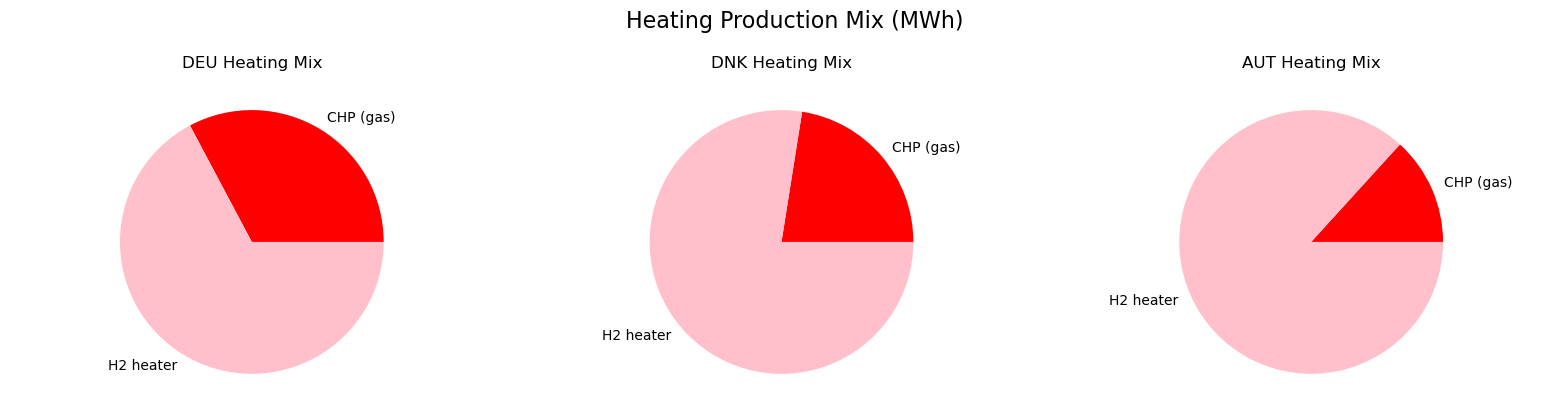

In [24]:
colors_heat = {
    'heat pump': 'green',
    'CHP (gas)': 'red',
    'H2 heater': 'pink'
}

plt.figure(figsize=(16, 4))

for i, country in enumerate(countries):
    labels = []
    sizes = []

    # Heat pump output (electricity -> heat)
    hp = f'heat_pump_{country}'
    if hp in n.links.index:
        value = -n.links_t.p1[hp].sum()  # flip sign
        if value > 0.1:
            labels.append('heat pump')
            sizes.append(value)

    # CHP output (gas -> electricity + heat)
    chp = f'CHP_{country}'
    if chp in n.links.index:
        value = -n.links_t.p2[chp].sum()  # flip sign
        if value > 0.1:
            labels.append('CHP (gas)')
            sizes.append(value)

    # H2 heater output
    h2 = f'H2_heater_{country}'
    if h2 in n.links.index:
        value = -n.links_t.p1[h2].sum()  # flip sign
        if value > 0.1:
            labels.append('H2 heater')
            sizes.append(value)

    if sizes:
        colors = [colors_heat[label] for label in labels]
        plt.subplot(1, 3, i + 1)
        plt.pie(sizes, labels=labels, colors=colors, wedgeprops={'linewidth': 0})
        plt.axis('equal')
        plt.title(f"{country} Heating Mix", y=1.07)
    else:
        plt.subplot(1, 3, i + 1)
        plt.text(0.5, 0.5, 'No heating', ha='center', va='center')
        plt.axis('off')

plt.suptitle("Heating Production Mix (MWh)", fontsize=16)
plt.tight_layout()
plt.show()


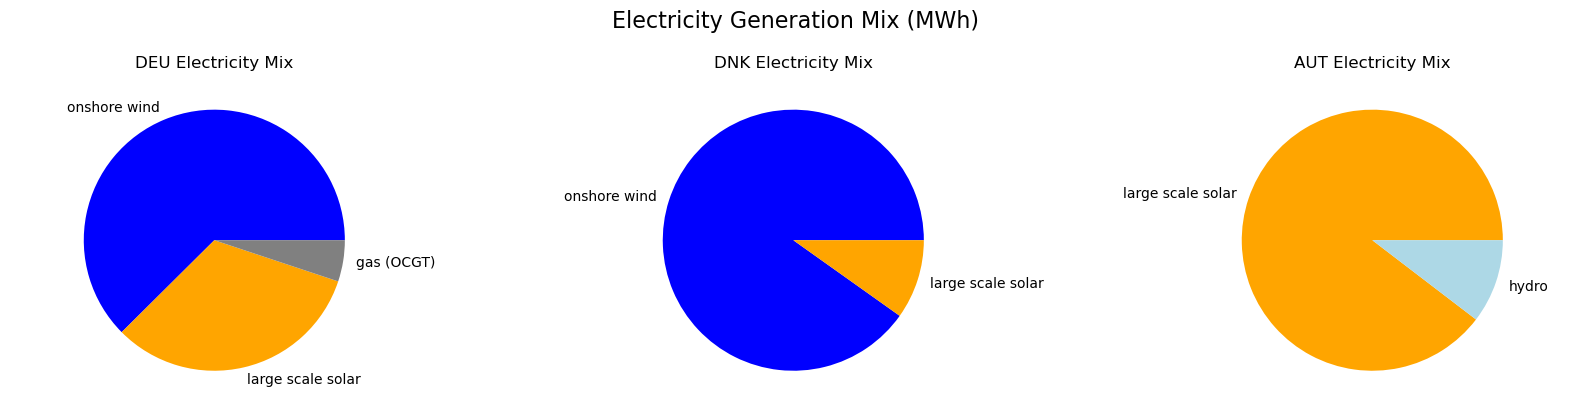

In [25]:
colors_gen = {
    'onshore wind': 'blue',
    'offshore wind': 'darkblue',
    'large scale solar': 'orange',
    'gas (OCGT)': 'grey',
    'coal': 'brown',
    'hydro': 'lightblue'
}

plt.figure(figsize=(16, 4))

for i, country in enumerate(countries):
    labels = []
    sizes = []

    # Onshore wind
    if f'onshorewind{country}' in n.generators.index:
        value = n.generators_t.p[f'onshorewind{country}'].sum()
        if value > 0.1:
            labels.append('onshore wind')
            sizes.append(value)

    # Offshore wind
    if f'offshorewind{country}' in n.generators.index:
        value = n.generators_t.p[f'offshorewind{country}'].sum()
        if value > 0.1:
            labels.append('offshore wind')
            sizes.append(value)

    # PV
    if f'PV{country}' in n.generators.index:
        value = n.generators_t.p[f'PV{country}'].sum()
        if value > 0.1:
            labels.append('large scale solar')
            sizes.append(value)

    # OCGT
    if f'OCGT{country}' in n.generators.index:
        value = n.generators_t.p[f'OCGT{country}'].sum()
        if value > 0.1:
            labels.append('gas (OCGT)')
            sizes.append(value)

    # Coal
    if f'coal{country}' in n.generators.index:
        value = n.generators_t.p[f'coal{country}'].sum()
        if value > 0.1:
            labels.append('coal')
            sizes.append(value)

    # Hydro (storage unit dispatch)
    if f"hydro{country}" in n.storage_units.index:
        value = n.storage_units_t.p[f"hydro{country}"].sum()
        if value > 0.1:
            labels.append('hydro')
            sizes.append(value)

    if sizes:
        colors = [colors_gen[label] for label in labels]
        plt.subplot(1, 3, i + 1)
        plt.pie(sizes, labels=labels, colors=colors, wedgeprops={'linewidth': 0})
        plt.axis('equal')
        plt.title(f"{country} Electricity Mix", y=1.07)
    else:
        plt.subplot(1, 3, i + 1)
        plt.text(0.5, 0.5, 'No generation', ha='center', va='center')
        plt.axis('off')

plt.suptitle("Electricity Generation Mix (MWh)", fontsize=16)
plt.tight_layout()
plt.show()


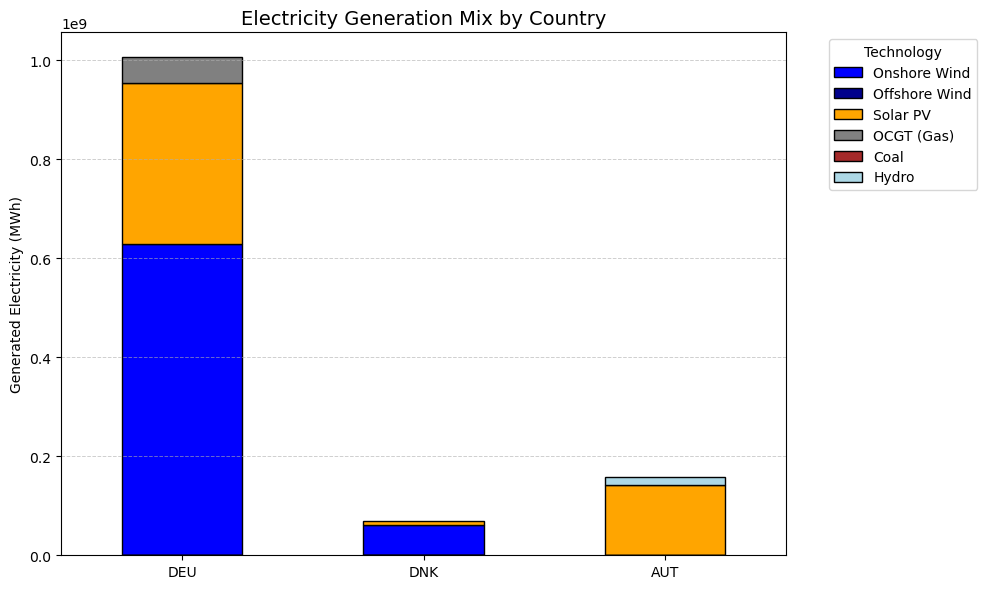

In [26]:
# Define the technologies and their labels/colors
tech_labels = {
    'onshorewind': 'Onshore Wind',
    'offshorewind': 'Offshore Wind',
    'PV': 'Solar PV',
    'OCGT': 'OCGT (Gas)',
    'coal': 'Coal',
    'hydro': 'Hydro'
}

colors = {
    'Onshore Wind': 'blue',
    'Offshore Wind': 'darkblue',
    'Solar PV': 'orange',
    'OCGT (Gas)': 'grey',
    'Coal': 'brown',
    'Hydro': 'lightblue'
}

# Initialize dataframe to collect generation by country and tech
df_gen = pd.DataFrame(0.0, index=tech_labels.values(), columns=countries)

for country in countries:
    for tech_key, tech_label in tech_labels.items():
        if tech_key == "hydro":
            unit_name = f"hydro{country}"
            if unit_name in n.storage_units.index:
                value = n.storage_units_t.p[unit_name].sum()
                df_gen.at[tech_label, country] = value
        else:
            gen_name = f"{tech_key}{country}"
            if gen_name in n.generators.index:
                value = n.generators_t.p[gen_name].sum()
                df_gen.at[tech_label, country] = value

# Plot
ax = df_gen.T.plot(kind='bar', stacked=True, color=[colors[t] for t in df_gen.index],
                   figsize=(10, 6), edgecolor='black')

plt.title("Electricity Generation Mix by Country", fontsize=14)
plt.ylabel("Generated Electricity (MWh)")
plt.xticks(rotation=0)
plt.legend(title="Technology", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6)
plt.tight_layout()
plt.show()


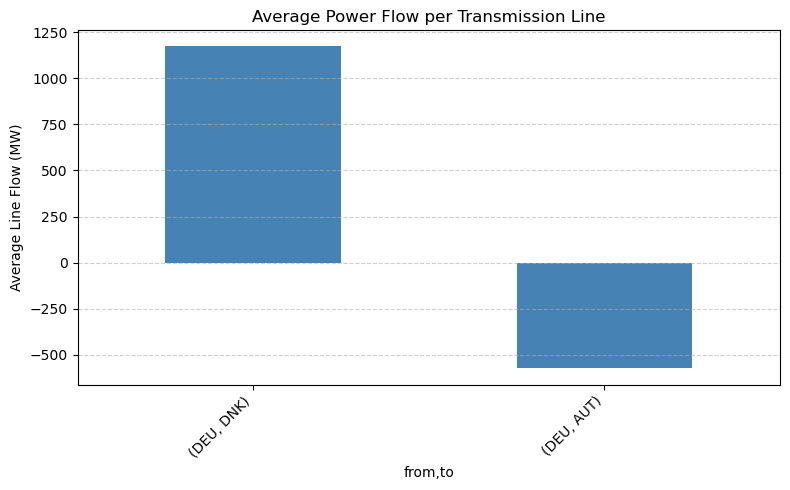

In [27]:
# Create a summary DataFrame
line_flows = pd.DataFrame(index=n.lines.index)
line_flows["from"] = n.lines.bus0
line_flows["to"] = n.lines.bus1
line_flows["average_flow_MW"] = n.lines_t.p0.mean()

# Plot as bar chart
plt.figure(figsize=(8, 5))
line_flows.set_index(["from", "to"])["average_flow_MW"].plot(kind='bar', color='steelblue')
plt.ylabel("Average Line Flow (MW)")
plt.title("Average Power Flow per Transmission Line")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

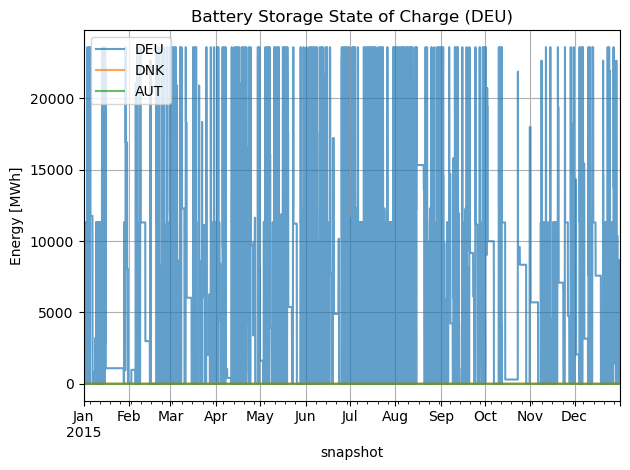

In [28]:
for country in countries:
    name = f"battery{country}"
    if name in n.storage_units_t.state_of_charge:
        n.storage_units_t.state_of_charge[name].plot(label=country, alpha=0.7)
plt.title("Battery Storage State of Charge (DEU)")
plt.ylabel("Energy [MWh]")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


In [29]:
n.stores.e_nom_opt['H2_tank_DEU']

650327.8224343078

Text(0, 0.5, 'Installed Capacity [MW]')

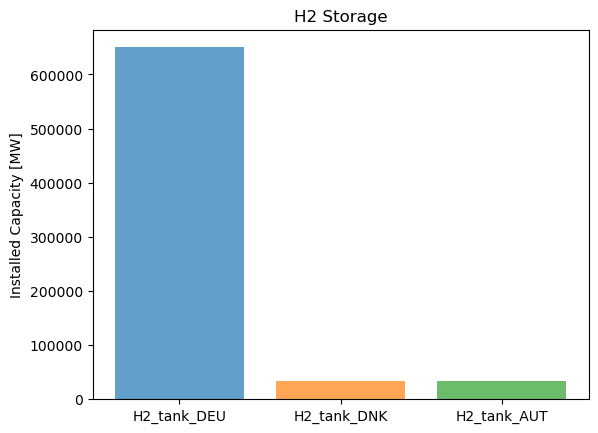

In [30]:
for country in countries:
    name = f"H2_tank_{country}"
    # bar plot of the state of charge
    plt.bar(name, 
            n.stores.e_nom_opt[name], label=country, alpha=0.7)
plt.title("H2 Storage")
plt.ylabel("Installed Capacity [MW]")
